<h1><center>Best Places to Invest an Airbnb Investment Property</center></h1>

<center>Code Part for Airbnb_Zillow Data Analysis<br>Xue Ni ni000054@umn.edu</center>

---

# Set Up and Data Loading

## Package Loading
Required Packages
- `Numpy`, `Pandas` - Data load andmanipulation
- `matplotlib`, `seaborn` - Data visualisation
- `fbprophet` - Time series forecasting


In [51]:
import numpy as np
import pandas as pd
import math
from fbprophet import Prophet # Forecasting

import matplotlib.pyplot as plt
import seaborn as sns
import pyplot_themes as themes
sns.set_style({'font.family':'Open Sans', 'font.serif':'Computer Modern Roman'})
plt.rcParams['font.sans-serif'] = "Open Sans"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [53]:
# set up display area to show dataframe in jupyter, for less truncating
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 500)

## Constant Variables

In [63]:
CITY = 'New York'
NUM_BEDROOM = 2
WORK_DIR = '' # where dataset is kept

## Data Loading
Revenue(Airbnb) and Cost(Zillow) datasets are loaded into Python-Enviroment for analysis.

In [3]:
import os
os.chdir(WORK_DIR)
zillow_data = pd.read_csv('Zip_Zhvi_2bedroom.csv')
zillow2020 = pd.read_csv('Zip_Zhvi_2bedroom_2020.csv', encoding='latin-1')

In [6]:
print(list_data.shape)
print(zillow2020.shape)

(48895, 106)
(26938, 293)


The airbnb listings data contains `48895` observations and `106` columns;  
The Zillow dataset contains `26938` rows and `293` columns

---

# Data Quality Check and Processing

Check data completeness, accuracy, validity and timeliness for both datasets  
Approach: Define helper functions for each perspective and apply functions on datasets

## Helper Functions for Data Quality Check

### Missing Values

In [7]:
# help fuction
def missing_check(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['pct'] = missing_df['missing_count']/df.shape[0]
    #missing_df = missing_df[missing_df['missing_count']>0]
    return missing_df

### Negative or Zero Valued Columns

Check negative or zero numerical values and see if those values make sense, if any. 

In [8]:
# Define a function to check negative or zero value of dataframe
def NegZero_check(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    temp_df = df.select_dtypes(include=numerics)
    NegZero = temp_df.where(temp_df<= 0).count().reset_index()
    NegZero.columns = ['column_name', 'NegZero_count']
    NegZero_df = NegZero[NegZero['NegZero_count']>0]
    NegZero_df['pct'] = NegZero_df['NegZero_count']/df.shape[0]
    return NegZero_df

### Duplicated Rows

In [9]:
def duplicated_check(df):
    return df[df.duplicated()].shape[0]

In [10]:
def remove_outlier(df2,col):
    df = df2.copy()
    df = df[np.abs(df.col-df.col.mean())<=(4*df.col.std())]
    return df 

---

## Cost Data

### Quality Check

In [11]:
missing_check(zillow_data)

,column_name,missing_count,pct
0,RegionID,0,0.000000
1,RegionName,0,0.000000
2,City,0,0.000000
3,State,0,0.000000
4,Metro,250,0.027945
...,...,...,...
257,2017-02,0,0.000000
258,2017-03,0,0.000000
259,2017-04,0,0.000000
260,2017-05,0,0.000000


In [12]:
missing_check(zillow2020)

,column_name,missing_count,pct
0,RegionID,0,0.000000
1,RegionName,0,0.000000
2,City,0,0.000000
3,State,0,0.000000
4,Metro,5728,0.212636
...,...,...,...
288,2019-09,0,0.000000
289,2019-10,0,0.000000
290,2019-11,0,0.000000
291,2019-12,0,0.000000


It shows that price for early years (1996.04-2013.07) has plenty of missing values. Therefore we need to handle them or will not use data of that time for our model.

In [48]:
NegZero_check(zillow_data)

,column_name,NegZero_count,pct


There is no Negative or Zero Values in all numeric columns.

In [16]:
duplicated_check(zillow_data)

0

There is no duplicated rows in the Zillow dataset.

---

### Filter & Clean Data

The various steps performed in the function are as follows:

1. Filter the data to include only New York City.

2. Select only relevant columns such as RegionName(zipcode) and the price of the property for last seven years to analysis. This is not only because of missing values in the early years, but also to guard against large outlier values (2008 Recession/Housing Price crash) - which may lead to flawed assumptions. 

3. In order to reduce number of columns to human-interpretable level, cost price across every year between 1996-2020 is tabulated in a vertical table. 

In [16]:
# This function is to filter city to CITY and keep last num_year years of data
def zillow_filter(df, CITY, num_year): 
    """
    CITY: city to filter
    num_year: number of last years to keep 
    """  
    df = df[df['City']== CITY].copy()  
    df = df.drop(["RegionID","City","State",'Metro','SizeRank'],axis=1).copy()    
    df = df.rename(columns={"RegionName": "zipcode", 'CountyName':'county'}).copy()
    
    df = df.iloc[:, np.r_[0:2, df.shape[1] - num_year*12: df.shape[1]]].copy()
    df['zipcode'] = df['zipcode'].astype(str).copy()
    return df

In [13]:
def county_map(df, col_county='county'):
    df2 = df.copy()
    county_dict = {'Bronx County':'Bronx', 'Kings County':'Brooklyn',
                'Queens County':'Queens','Richmond County':'Staten Island','New York County':'Manhattan',
                  'New York':'Manhattan','Richmond':'Staten Island',
                   'Kings':'Brooklyn','Queens':'Queens'}

    df2= df2[df2[col_county]!='Cortland County']
    df2[col_county] = df2[col_county].map(county_dict)
    df2 = df2.rename(columns={col_county:'borough'})
    return df2 

In [14]:
# This function is to tabulate data from 'wide' to 'long' 
def zillow_processing(df):
    df = pd.melt(df, id_vars=['zipcode','borough'], value_vars=list(df.columns[2:]))
    df = df.rename(columns={'variable':'yr_mth'}).copy()
    df['yr_mth'] = pd.to_datetime(df['yr_mth'])   
    df['zipcode'] = df['zipcode'].astype(str).copy()
    return df

In [17]:
# apply above helper function to zillow data
cost10year = county_map(zillow_filter(zillow2020, CITY, 10))

In [18]:
z_nyc = zillow_processing(cost10year)

In [19]:
nyc_cost_2020 =  z_nyc.loc[z_nyc['yr_mth'] == '2020-01-01', ['zipcode','borough','value']]

---

## Revenue Data

### Quality Check

In [20]:
list_data = list_data[list_data['bedrooms']==2].copy()

In [21]:
# Only check above relevent columns

airbnb_cols = ['neighbourhood_group_cleansed',
               'city', 'state', 'zipcode','property_type', 
               'room_type','bathrooms', 'bedrooms', 
               'price', 'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee', 
               'number_of_reviews', 'review_scores_rating', 'review_scores_value','reviews_per_month']

list_data = list_data[airbnb_cols]

In [22]:
missing_check(list_data)

,column_name,missing_count,pct
0,neighbourhood_group_cleansed,0,0.000000
1,city,9,0.001385
2,state,1,0.000154
3,zipcode,50,0.007696
4,property_type,0,0.000000
5,room_type,0,0.000000
6,bathrooms,3,0.000462
7,bedrooms,0,0.000000
8,price,0,0.000000
9,weekly_price,5707,0.878405


In [23]:
NegZero_check(list_data)

,column_name,NegZero_count,pct
0,bathrooms,4,0.000616
2,number_of_reviews,1280,0.197014


In [97]:
duplicated_check(list_data)

0

### Filter and Clean Revenue Data

Define Function for Revenue Data Filtering and Cleaning
1. Filter listings having 2 `bedroom`s and only keep relevent columns
2. `Price` column: remove dollar sign and comma; remove observations with zero price; convert to numeric
3. `zipcode` column: trim zipcodes longer than 5 digits and pad ones shorter than 5; convert zipcode into strings

In [31]:
def airbnb_processing(df_airbnb,numberOfBedroom):
    
    # filter out listings for 2 bedrooms
    df_airbnb = df_airbnb[df_airbnb['bedrooms']==numberOfBedroom].copy()
    relevantcol = ['zipcode','neighbourhood_group_cleansed',"price"]
    
    # due to the incompleteness of weekly price and monthly price, only use price for analysis
    df_airbnb = df_airbnb[relevantcol].rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}).copy()

    # remove observations with null in zipcode
    df_airbnb = df_airbnb[df_airbnb['zipcode'].notnull()].copy()
    
    # Remove the commas and dollars signs from the price column
    df_airbnb['price'] = df_airbnb['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
 
    # There are mixed data types in zipcode column with difference length and formats, convert them all in string and remove noisy characters
    df_airbnb['zipcode'] = df_airbnb['zipcode'].astype(str).replace('\.0', '', regex=True).str.zfill(5).str[:5].copy()
    
    # remove listings with $0 price
    df_airbnb = df_airbnb[df_airbnb['price']>0].copy()
    
    return df_airbnb

In [27]:
airbnb_2b = airbnb_processing(list_data,NUM_BEDROOM)

---

### Data Integrity

In [32]:
# Check if zipcode vs neighbourhood is one-to-one mapping
def One2One(df, col1, col2):
    df2 = df.groupby([col1,col2]).size().reset_index()
    df3 = pd.DataFrame(df2.groupby(col1).size(), columns=['count'])
    if not df3[df3['count']>1].empty:
        df4=df3[df3['count']>1]
        outlier_ix = df4.index.values[0]
        df_copy = df.copy()
        df_copy.set_index(col1, inplace=True)
        df_outlier = df_copy.ix[df4.index]
        df.loc[df[col1]==outlier_ix,col2] = df_outlier[col2].mode().values[0]
    return df

In [33]:
# Check if zipcode vs country is one-to-one mapping
def one_mapping(df, col1, col2):
    result = True
    #df2 = df.groupby([col1,col2]).size().reset_index()
   # df3 = pd.DataFrame(df2.groupby(col1).size(), columns=['count'])
   # if not df3[df3['count']>1].empty:result = False
    result = df.ffill().groupby(col1)[col2].apply(lambda x: x.nunique() == 1).all()
    return result

In [34]:
one_mapping(airbnb_2b, 'zipcode', 'neighbourhood')

False

In [35]:
def unify_neighbor(df, col1, col2):
    df[col1].fillna(-1, inplace=True)
    zip_neighbor = df.groupby(col1)[col2].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
    df.drop([col2], axis=1, inplace=True)
    df = df.merge(zip_neighbor, on=col1,how='left')
    df.loc[df[col1] == -1, col2] = np.nan
    return df

In [36]:
airbnb_2b = unify_neighbor(airbnb_2b, 'zipcode', 'neighbourhood')

### Remove Outlier

In [37]:
airbnb_2b = airbnb_2b.groupby('neighbourhood').apply(lambda x : \
         x[np.abs(x.price-x.price.mean())<=(3*x.price.std())]).droplevel(0)

In [1529]:
airbnb_2b_3 = airbnb_2b[airbnb_2b.groupby('neighbourhood')['price'].\
          transform(lambda x : (x<x.quantile(0.98))&(x>(x.quantile(0.05)))).eq(1)]

In [62]:
airbnb_2b.groupby('neighbourhood')['price'].quantile(.999)

neighbourhood
Bronx             299.909
Brooklyn          700.000
Manhattan        1209.250
Queens            452.235
Staten Island     199.946
Name: price, dtype: float64

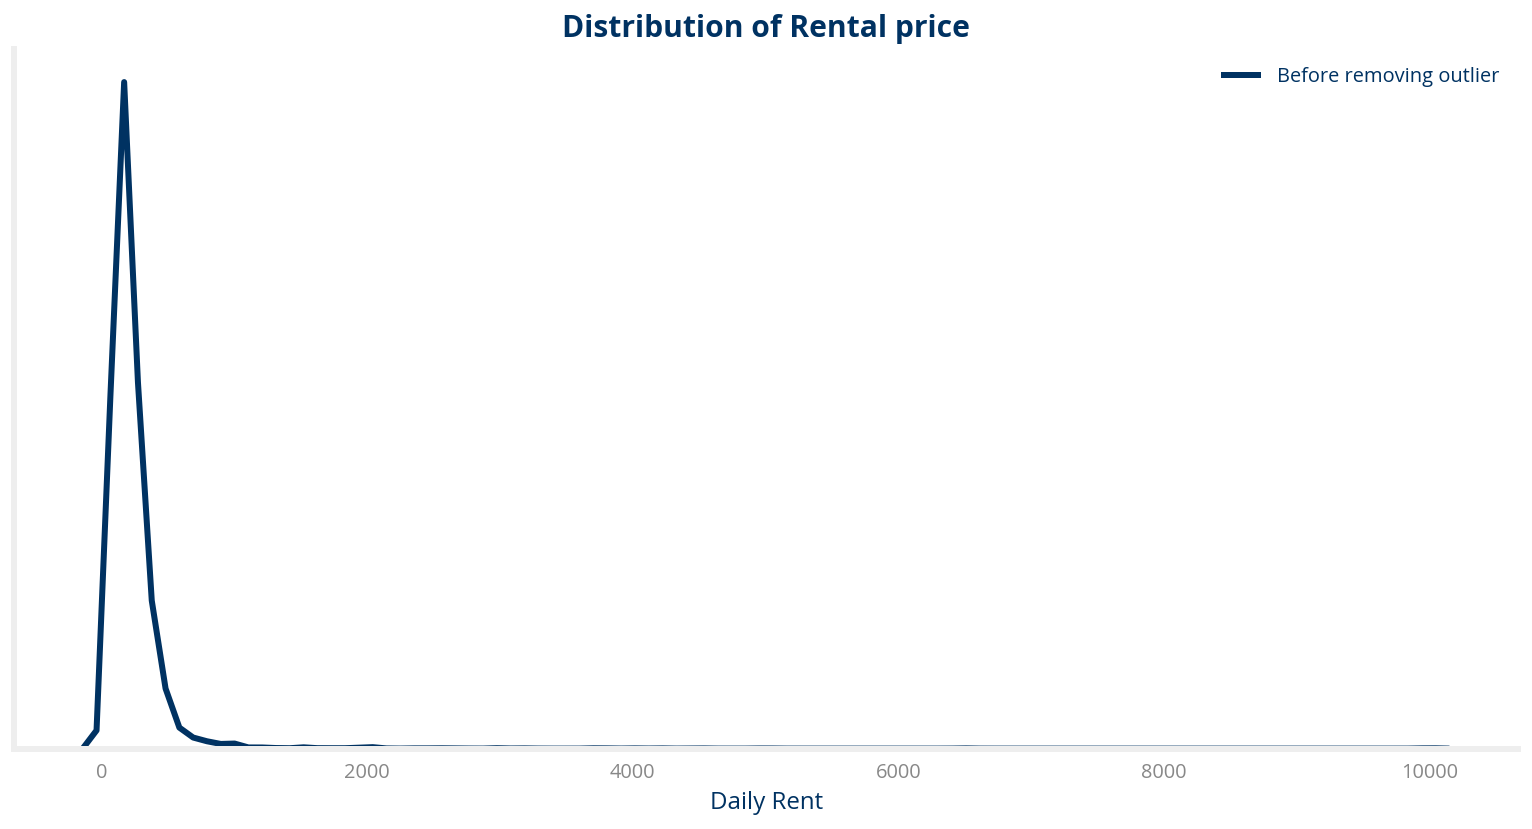

In [1512]:
plt.figure(figsize=(12,6))

themes.theme_ucberkeley(scheme="all")

g=sns.distplot(airbnb_2b[['price']], hist=False, rug=False,
             kde_kws={ "lw": 3, "label": "Before removing outlier"})
g.set(yticks=[])

plt.xlabel('Daily Rent',fontsize=12)
plt.title('Distribution of Rental price',fontsize=15, weight='bold')
plt.show()


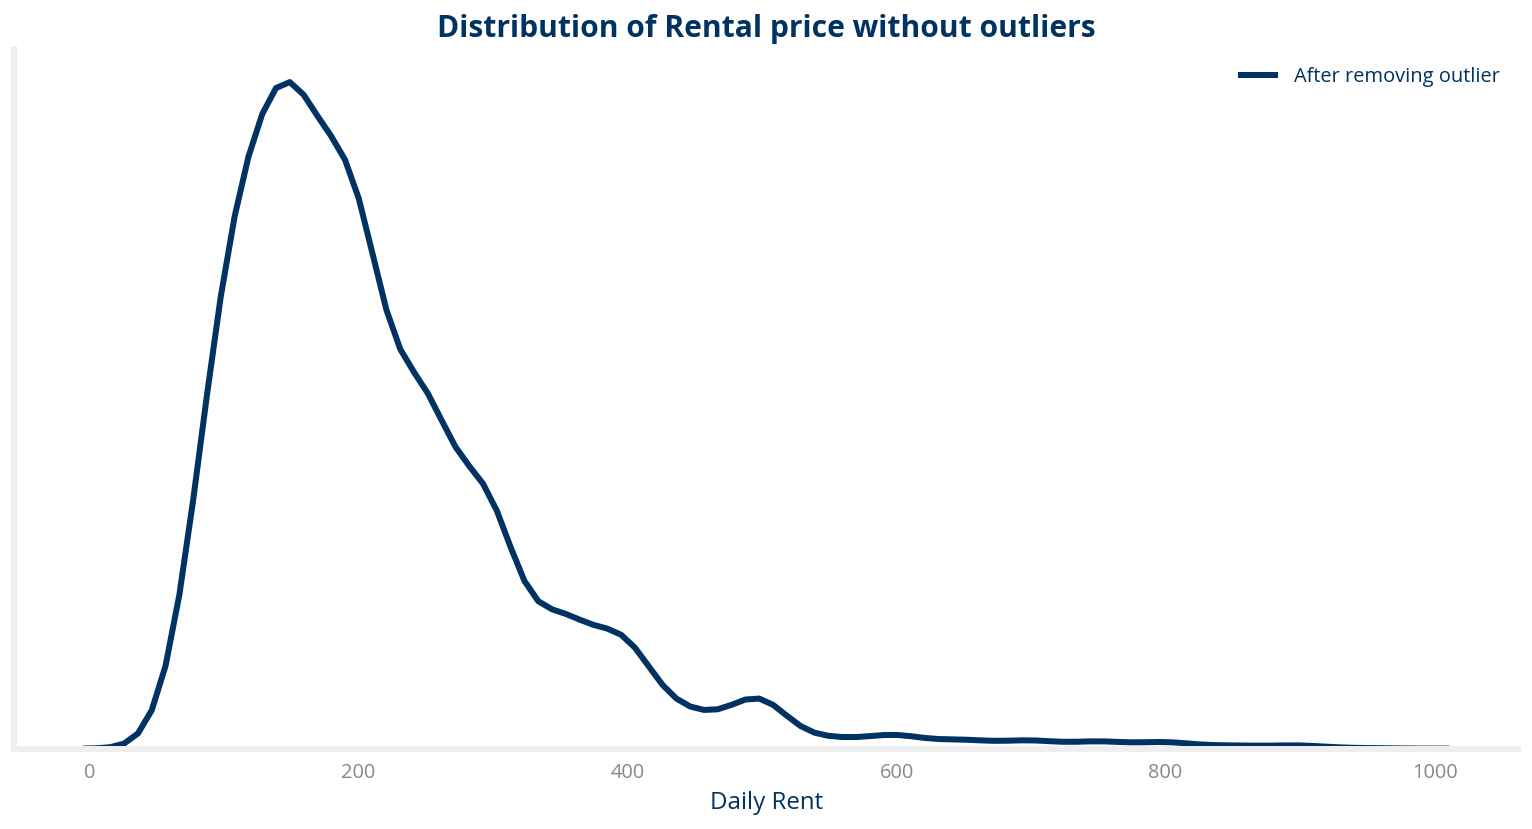

In [1530]:
plt.figure(figsize=(12,6))

themes.theme_ucberkeley(scheme="all")
g=sns.distplot(airbnb_2b_3[['price']], hist=False, rug=False,
                         kde_kws={ "lw": 3, "label": "After removing outlier"})

g.set(yticks=[])

plt.xlabel('Daily Rent',fontsize=12)
plt.title('Distribution of Rental price without outliers',fontsize=15, weight='bold')
plt.show()

---

## Data Merging

In [40]:
nyc_cost_2020 =  z_nyc.loc[z_nyc['yr_mth'] == '2020-01-01', ['zipcode','borough','value']]

In [41]:
def merge_air_cost(revenue_df, cost_df):   
    combine_data = revenue_df[['zipcode','price']].merge(cost_df, how='inner',on='zipcode')
    return combine_data

### CAGR of housing price

In [45]:
cost_med_yr = z_nyc.groupby(['zipcode','borough','yr_mth'],as_index=False)['value'].median()
d_new_yr = cost_med_yr.set_index(['yr_mth'])
d_new_yr = d_new_yr.groupby(['zipcode','borough']).resample('Y').mean().reset_index()
d_new_yr['year'] = d_new_yr['yr_mth'].dt.year

y = d_new_yr[d_new_yr['year']>=2016]
last = y.groupby(['zipcode','borough'])['value'].last()
first = y.groupby(['zipcode','borough'])['value'].first()
cagr5 = ((last/first)**(1/5)-1).to_frame().reset_index().rename(columns={'value':'cagr5'})
cagr5

,zipcode,borough,cagr5
0,10001,Manhattan,-0.014487
1,10002,Manhattan,-0.005574
2,10003,Manhattan,-0.016040
3,10004,Manhattan,-0.027573
4,10005,Manhattan,-0.025643
...,...,...,...
170,11436,Queens,0.046899
171,11691,Queens,0.034645
172,11692,Queens,0.037859
173,11693,Queens,0.038501


In [46]:
cost_cagr = nyc_cost_2020.merge(cagr5[['zipcode',
                                       'cagr5']],on='zipcode',how='left').rename(columns={'value':'cost2020'})

cost_cagr['cost2025'] = cost_cagr['cost2020'] * (cost_cagr['cagr5']+1)**5
cost_cagr['cost2030'] = cost_cagr['cost2025'] * (cost_cagr['cagr5']+1)**5

In [47]:
newdata_2020 = merge_air_cost(airbnb_2b, cost_cagr[['zipcode', 'borough', 'cost2020', 'cost2025','cost2030']]) 

In [48]:
temp=z_nyc[z_nyc['yr_mth']=='2019-07-01']
newdata_2020 = newdata_2020.merge(temp[['zipcode','value']],
                                how='inner',on='zipcode').rename(columns={'value':'cost2019'})

### Number of Property

In [49]:
t = newdata_2020.groupby('zipcode').size()
newdata_2020= newdata_2020.merge(t.rename('num_property'), left_on='zipcode', right_index=True)

#### Remove zipcodes with .25 quantile density within the borough

In [1236]:
newdata_2020_2 = newdata_2020.groupby('borough').apply(lambda x : \
          x[x.num_property > x.num_property.quantile(0.25)]).droplevel(0)

In [1604]:
newdata_2020_3 = newdata_2020[newdata_2020.num_property > newdata_2020.num_property.quantile(0.1)]


In [1540]:
newdata_2020_3.borough.nunique()

4

---

# Exploratory Data Analysis and Visualization

In [30]:
self_palette ={'Brooklyn':'#56bdff',
            'Manhattan':  '#07335d',
               'Staten Island':'#a9aaab', 
               'Queens':'#ff9856',
               'Bronx':'#ecd1cb'}

## Housing Price in NYC Over Years

### NYC Price Median

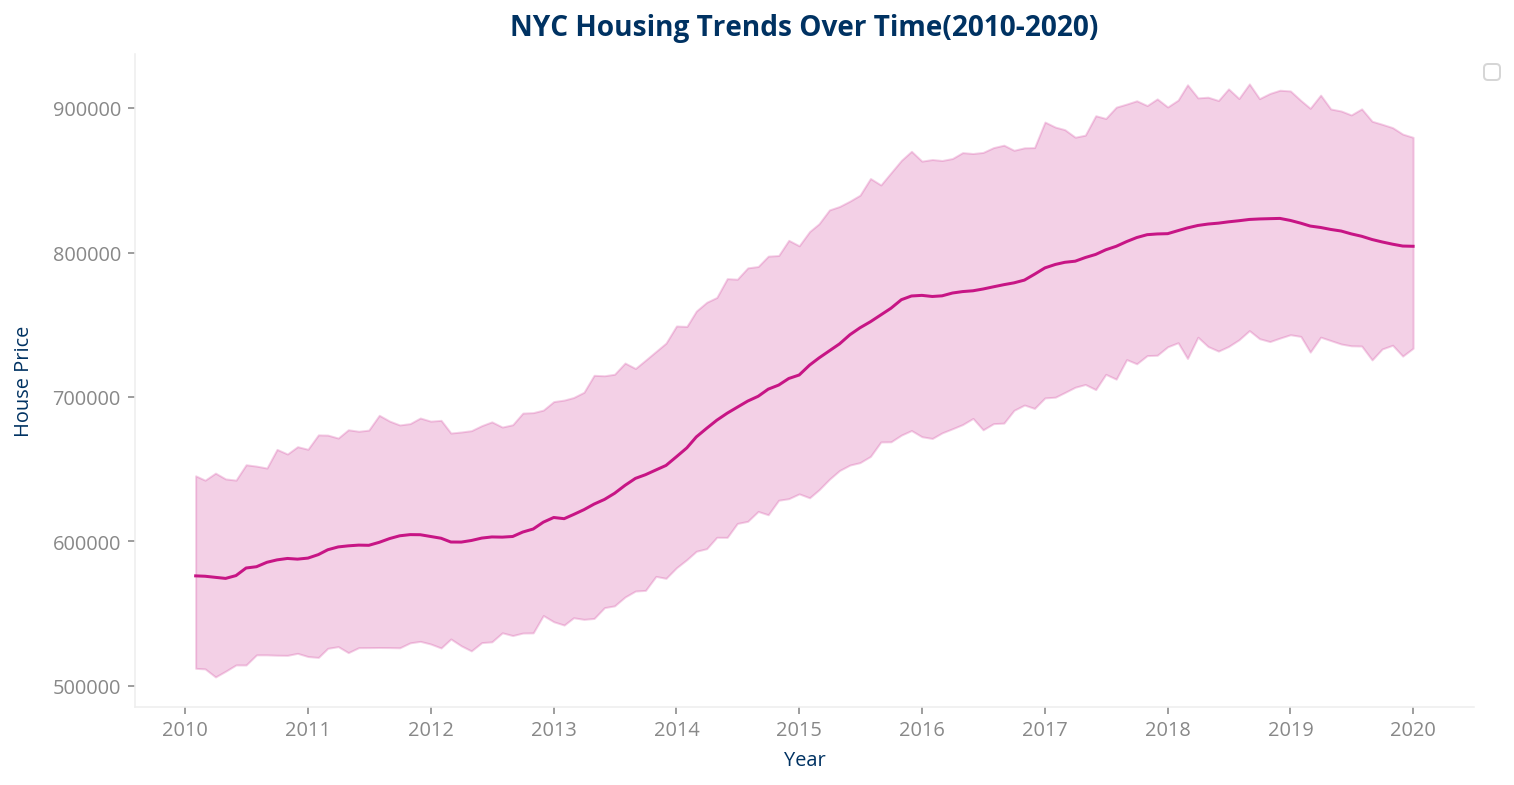

In [53]:
# Code generating Fig1 in the report # Median housing price from 1997 to 2017

themes.theme_ucberkeley()
data = z_nyc[z_nyc['zipcode'].isin(newdata_2020.zipcode.unique())]
#themes.theme_fivethirtyeight()

plt.figure(figsize=(12,6))
sns.lineplot(data = data, x='yr_mth', y='value',color='mediumvioletred')
plt.xlabel('Year',fontsize=10,labelpad=5)
plt.ylabel('House Price',fontsize=10,labelpad=9)
plt.title("NYC Housing Trends Over Time(2010-2020)", fontsize=14,y=1.01,weight='bold')

#plt.legend(loc='upper right')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.show()

### By borough

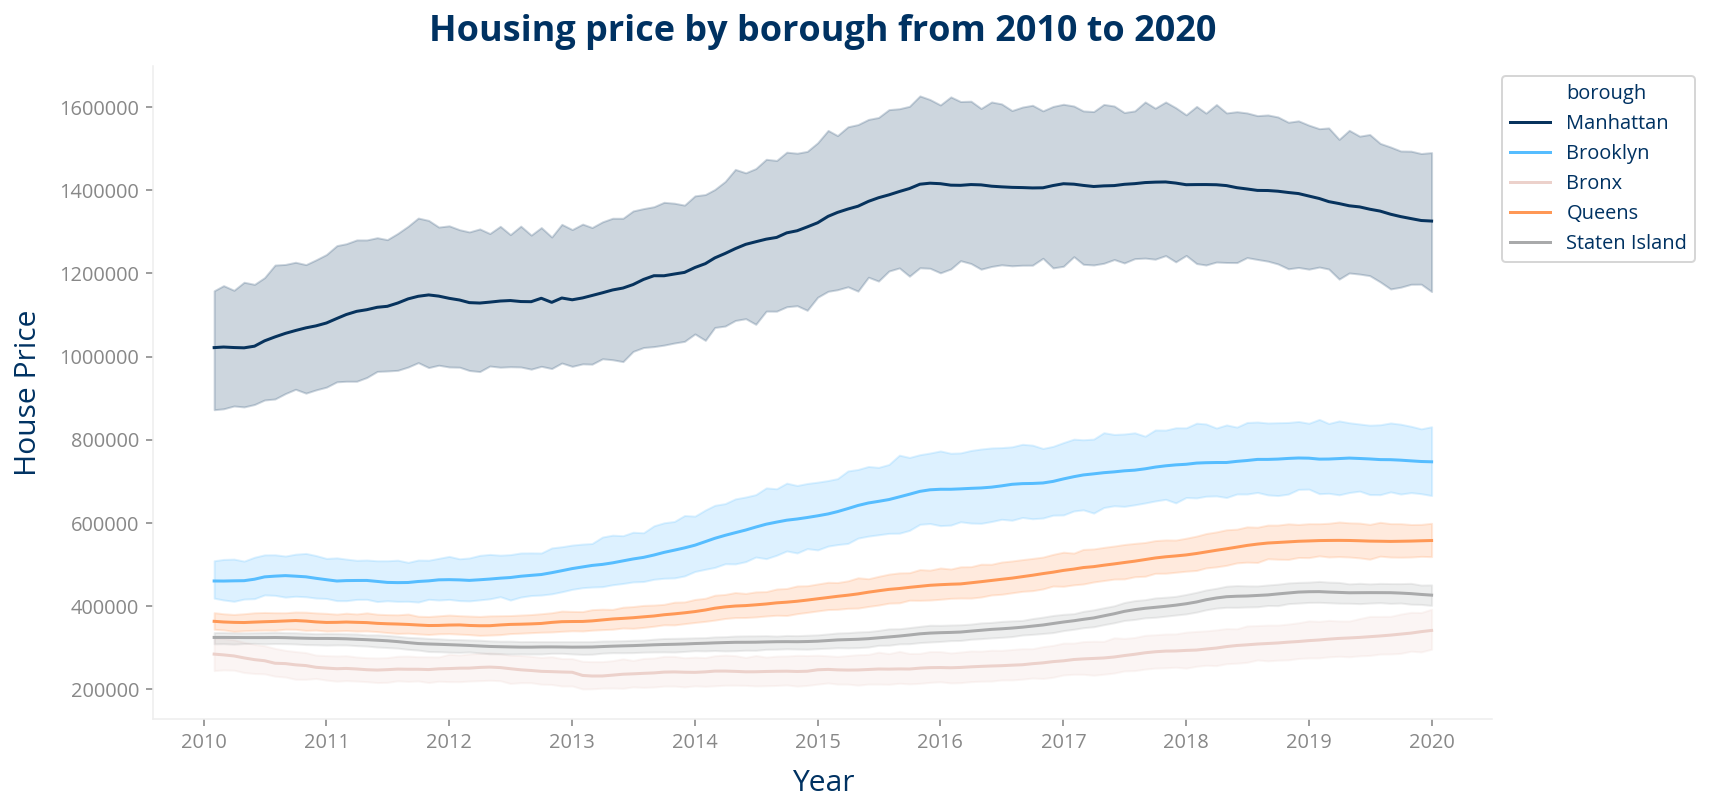

In [55]:
# Code generating Fig2 in the report  # Median housing price within neighbourhood from 1997 to 2017
from numpy import median 
plt.figure(figsize=(12,6))

themes.theme_ucberkeley()
#themes.theme_fivethirtyeight()
data = z_nyc[z_nyc['zipcode'].isin(newdata_2020.zipcode.unique())]

sns.lineplot(data = data, x='yr_mth', y='value',
             hue='borough',
             palette=self_palette,
            )
plt.xlabel('Year',fontsize=15,labelpad=8)
plt.ylabel('House Price',fontsize=15,labelpad=8)
plt.title('Housing price by borough from 2010 to 2020',fontsize=18, y=1.02,weight='bold')

plt.legend(loc='upper right')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.show()

## Housing Price YoY Growth in NYC

### Median price change by borough

In [1316]:
borough_med = newdata_2020_3[['borough','cost2020','cost2025']].groupby(['borough'],as_index=False).median()
borough_med=borough_med.melt(id_vars='borough', value_vars=['cost2020','cost2025'])
borough_med

,borough,variable,value
0,Brooklyn,cost2020,934965.00
1,Manhattan,cost2020,1358710.00
2,Queens,cost2020,698091.00
3,Staten Island,cost2020,485517.00
4,Brooklyn,cost2025,1009855.33
5,Manhattan,cost2025,1244693.67
6,Queens,cost2025,840253.34
7,Staten Island,cost2025,608645.84


In [1486]:
price_intersec = z_nyc[z_nyc['zipcode'].isin(newdata_2020_3.zipcode.unique())]
borough = price_intersec.groupby(['borough','yr_mth'],as_index=False)['value'].median()
d_new1 = borough.set_index(['yr_mth'])
d_new2 = d_new1.groupby('borough').resample('Y').mean()
d_new_pct = d_new2.groupby(level='borough').pct_change().reset_index()
d_new_pct['year']=d_new_pct['yr_mth'].dt.year

In [1286]:
df_borough = d_new2.reset_index()
df_borough['year'] =df_borough['yr_mth'].dt.year
df_borough= df_borough[['borough','year','value']]
df_graph = df_borough[(df_borough['year']==2015) | (df_borough['year']==2020)]
df_graph = df_graph.pivot_table(values='value', index='borough', columns=['year']).reset_index()

In [1307]:
df_graph['cagr']= (df_graph[2020]/df_graph[2015])**(1/5)-1
df_graph[2025] = df_graph[2020] * (1+df_graph['cagr'])**5
df_graph = df_graph.drop('cagr', axis=1).melt(id_vars='borough', value_vars=[2015,2020,2025])
df_graph

,borough,year,value
0,Bronx,2015,234028.83
1,Brooklyn,2015,558154.25
2,Manhattan,2015,1458711.17
3,Queens,2015,405876.88
4,Staten Island,2015,329755.71
5,Bronx,2020,304499.00
6,Brooklyn,2020,665321.00
7,Manhattan,2020,1350364.50
8,Queens,2020,525611.00
9,Staten Island,2020,432463.00


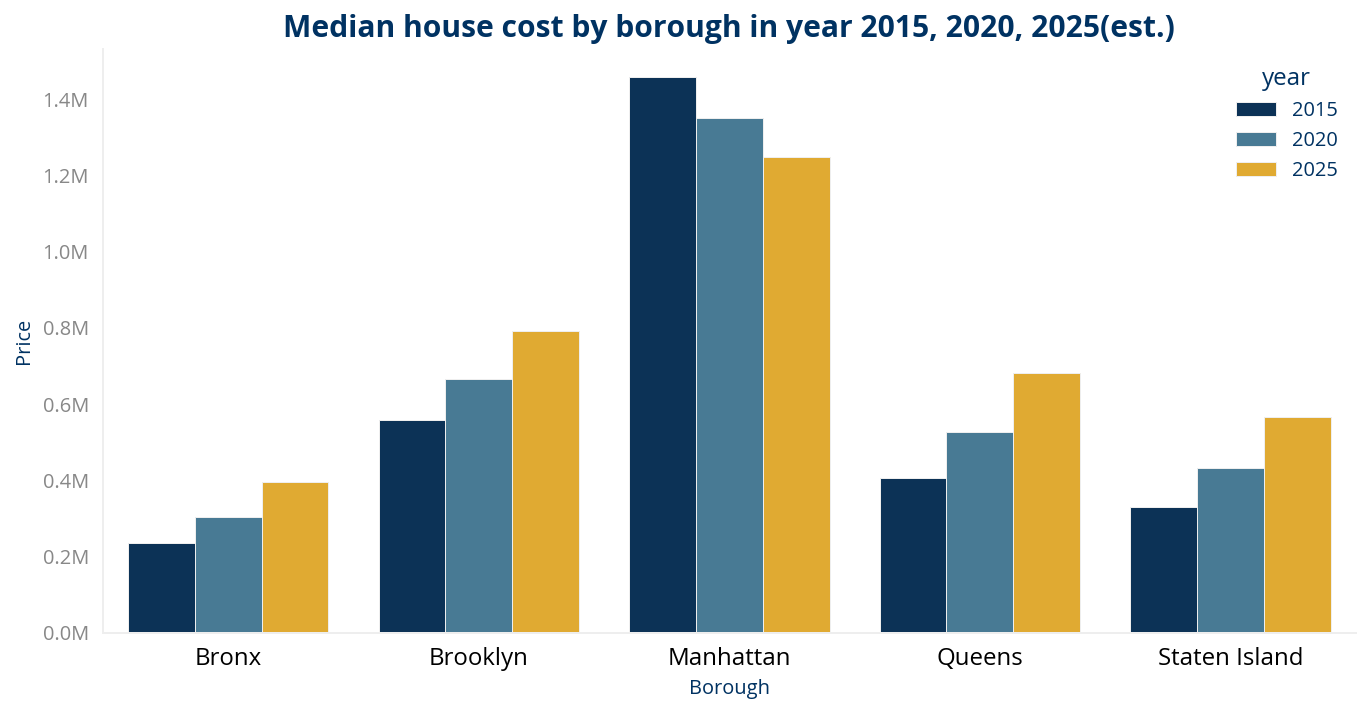

In [1410]:
# Code generating Fig5 in the report  # Number of properties by neighbourhood
import matplotlib

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
themes.theme_ucberkeley(scheme="all")

sns.barplot(x="borough", y="value",hue = 'year',dodge=True,  data=df_graph, 
            #palette=('#ff604a','#ff9856','#575fcf')
           )
ax.tick_params(axis = 'x', which = 'major', labelsize = 12,labelcolor='black')
plt.title('Median house cost by borough in year 2015, 2020, 2025(est.)', fontsize=15, weight='bold')
plt.xlabel('Borough', fontsize=10)

#set y axis format
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1000000) + 'M'))
plt.ylabel('Price', fontsize=10)
plt.show()

### House Price pct change by borough

In [1122]:
cost_mean_yr = z_nyc.groupby(['zipcode','borough','yr_mth'],as_index=False)['value'].mean()
cost_med_yr = z_nyc.groupby(['zipcode','borough','yr_mth'],as_index=False)['value'].median()

d_new_yr = cost_mean_yr.set_index(['yr_mth'])
d_new_yr = d_new_yr.groupby(['zipcode','borough']).resample('Y').mean().reset_index()
d_new_yr['year'] = d_new_yr['yr_mth'].dt.year

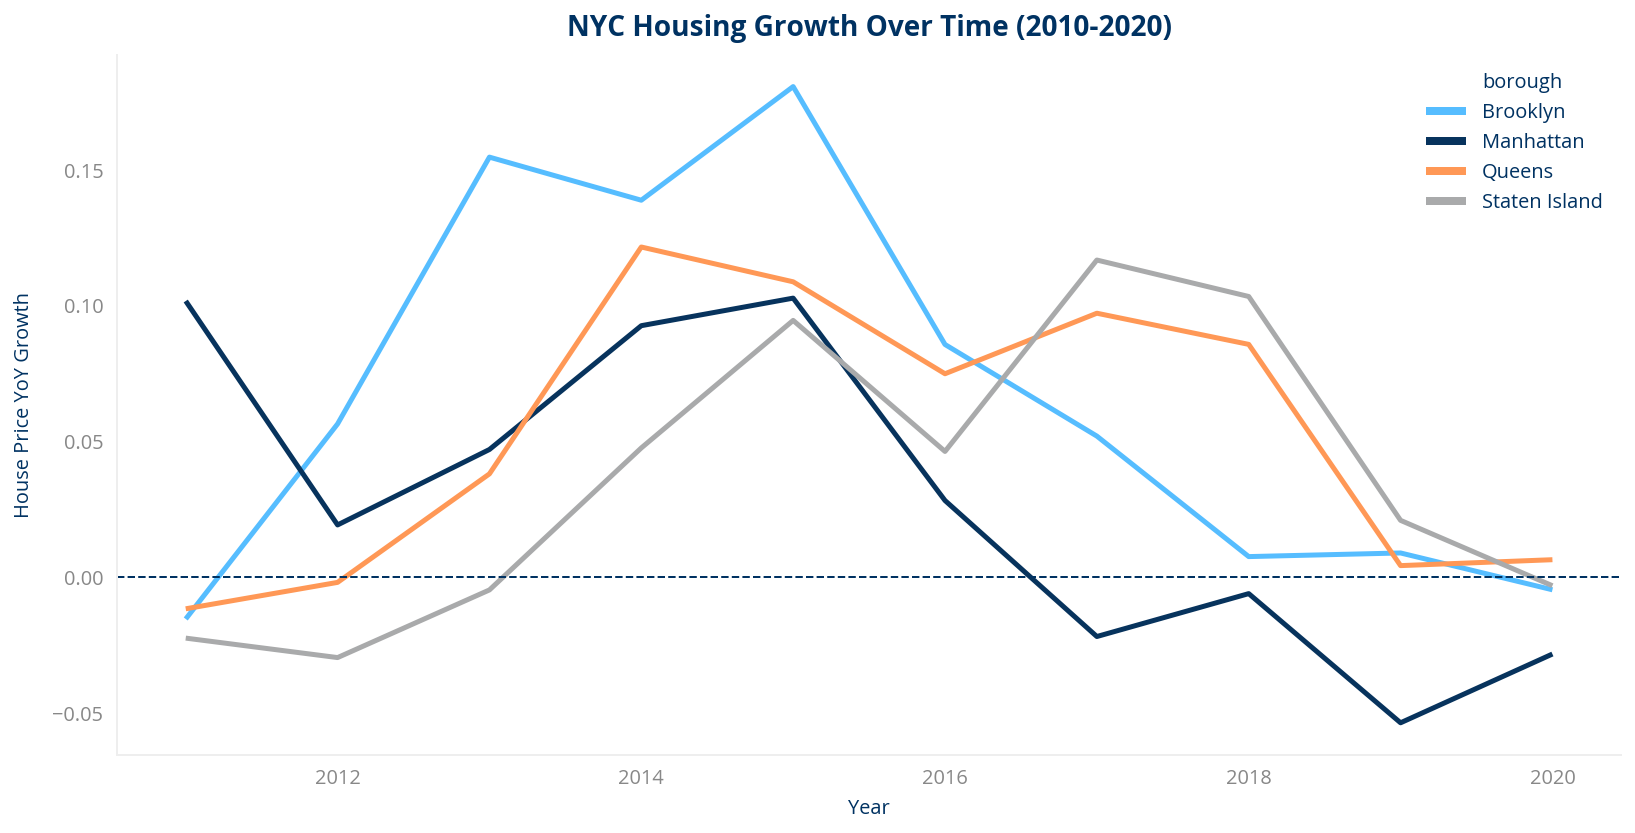

In [1488]:
themes.theme_ucberkeley()

plt.figure(figsize=(12,6))

sns.lineplot(data = d_new_pct, x='year', y='value',hue='borough', linewidth=2.5,   
           palette = self_palette,
            )
plt.axhline(0, ls='--', lw=1)

plt.xlabel('Year',fontsize=10,labelpad=5)
plt.ylabel('House Price YoY Growth',fontsize=10,labelpad=9)
plt.title("NYC Housing Growth Over Time (2010-2020)", fontsize=14,y=1.01,weight='bold')

plt.legend(loc='upper right')
plt.show()

In [1126]:
cost_mean_yr2 = z_nyc.groupby(['yr_mth'],as_index=False)['value'].mean()
d_new_yr2 = cost_mean_yr2.set_index(['yr_mth'])
d_new_yr2 = d_new_yr2.resample('Y').mean().reset_index()
d_new_yr2['year'] = d_new_yr2['yr_mth'].dt.year 
nyc_yoy=d_new_yr2['value'].pct_change()

---

## Airbnb Rental Price within Neighborhood

<Figure size 1080x648 with 0 Axes>

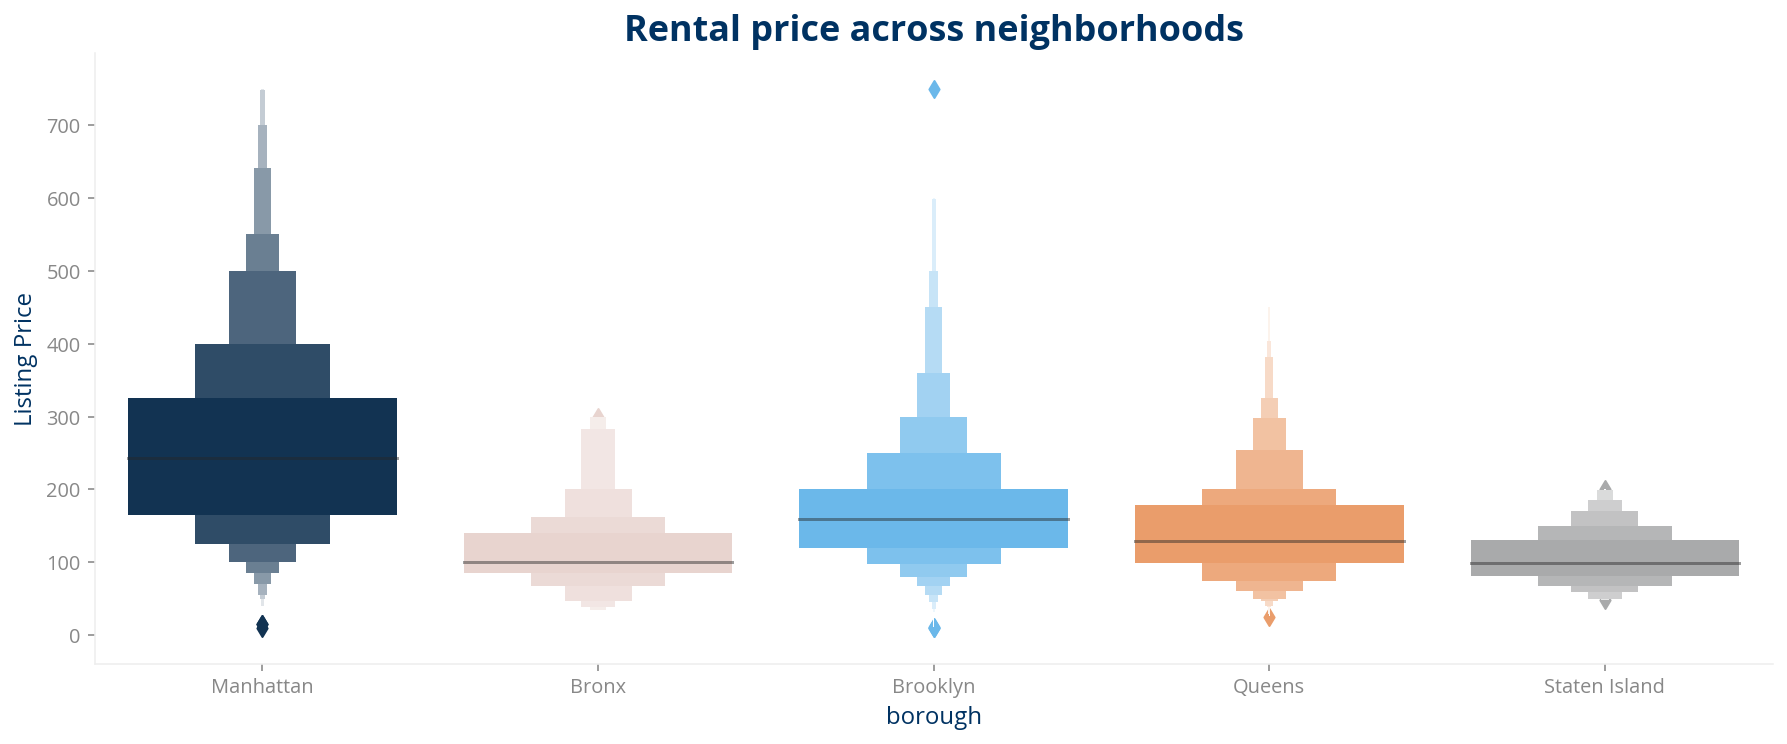

In [56]:
# Code generating Fig3 in the report  # Airbnb rental price within neighbourhood in 2019
plt.figure(figsize=(15,9))

themes.theme_ucberkeley(scheme="all")

df = newdata_2020[np.abs(newdata_2020.price-newdata_2020.price.mean())<=(4*newdata_2020.price.std())]
# Remove records with listing prices that are more than 3 standard deviations from the mean

sns.catplot(x='borough', y="price", kind="boxen", data=df, palette = self_palette,
            height=5, # make the plot 5 units high
            aspect=2.5) # height should be 3 times width
plt.xlabel('borough',fontsize=12)
plt.ylabel('Listing Price',fontsize=12)
plt.title('Rental price across neighborhoods',fontsize=18, y=1.2, weight='bold')
plt.show()

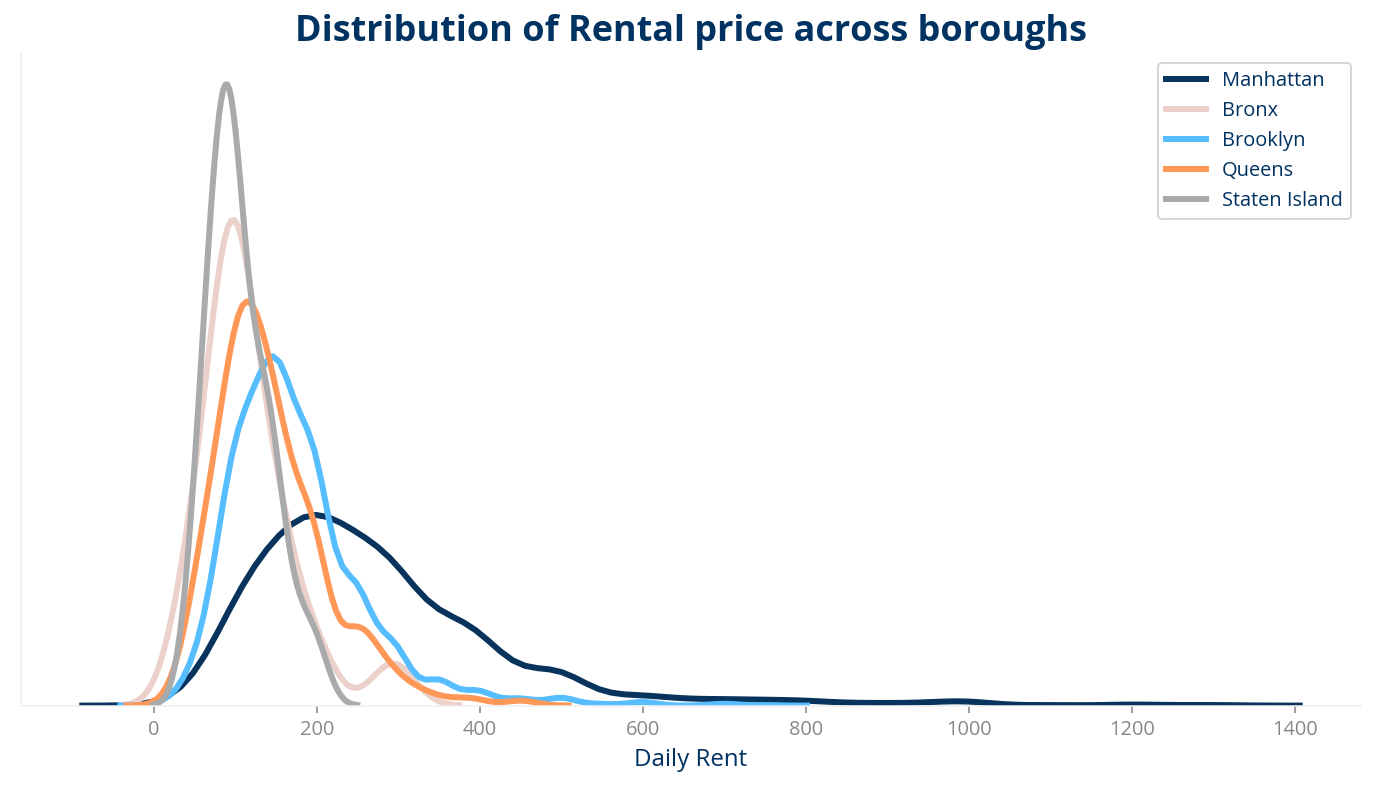

In [57]:
plt.figure(figsize=(12,6))
themes.theme_ucberkeley(scheme="all")

b1 = newdata_2020.loc[newdata_2020['borough'] == 'Manhattan']
b2 = newdata_2020.loc[newdata_2020['borough'] == 'Bronx']
b3 = newdata_2020.loc[newdata_2020['borough'] == 'Brooklyn']
b4 = newdata_2020.loc[newdata_2020['borough'] == 'Queens']
b5 = newdata_2020.loc[newdata_2020['borough'] == 'Staten Island']

g=sns.distplot(b1[['price']], hist=False, rug=False,
             kde_kws={ 'color':'#07335d', "lw": 3, "label": "Manhattan"})
sns.distplot(b2[['price']], hist=False, rug=False,color='#ecd1cb',
             kde_kws={ "lw": 3, "label": "Bronx"})
sns.distplot(b3[['price']], hist=False, rug=False,color = '#56bdff',
            kde_kws={ "lw": 3, "label": "Brooklyn"})
sns.distplot(b4[['price']], hist=False, rug=False,color='#ff9856',
            kde_kws={ "lw": 3, "label": "Queens"})
sns.distplot(b5[['price']], hist=False, rug=False,color='#a9aaab',
            kde_kws={ "lw": 3, "label": "Staten Island"})
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

g.set(yticks=[])

plt.xlabel('Daily Rent',fontsize=12)
plt.title('Distribution of Rental price across boroughs',fontsize=18, weight='bold')
plt.show()

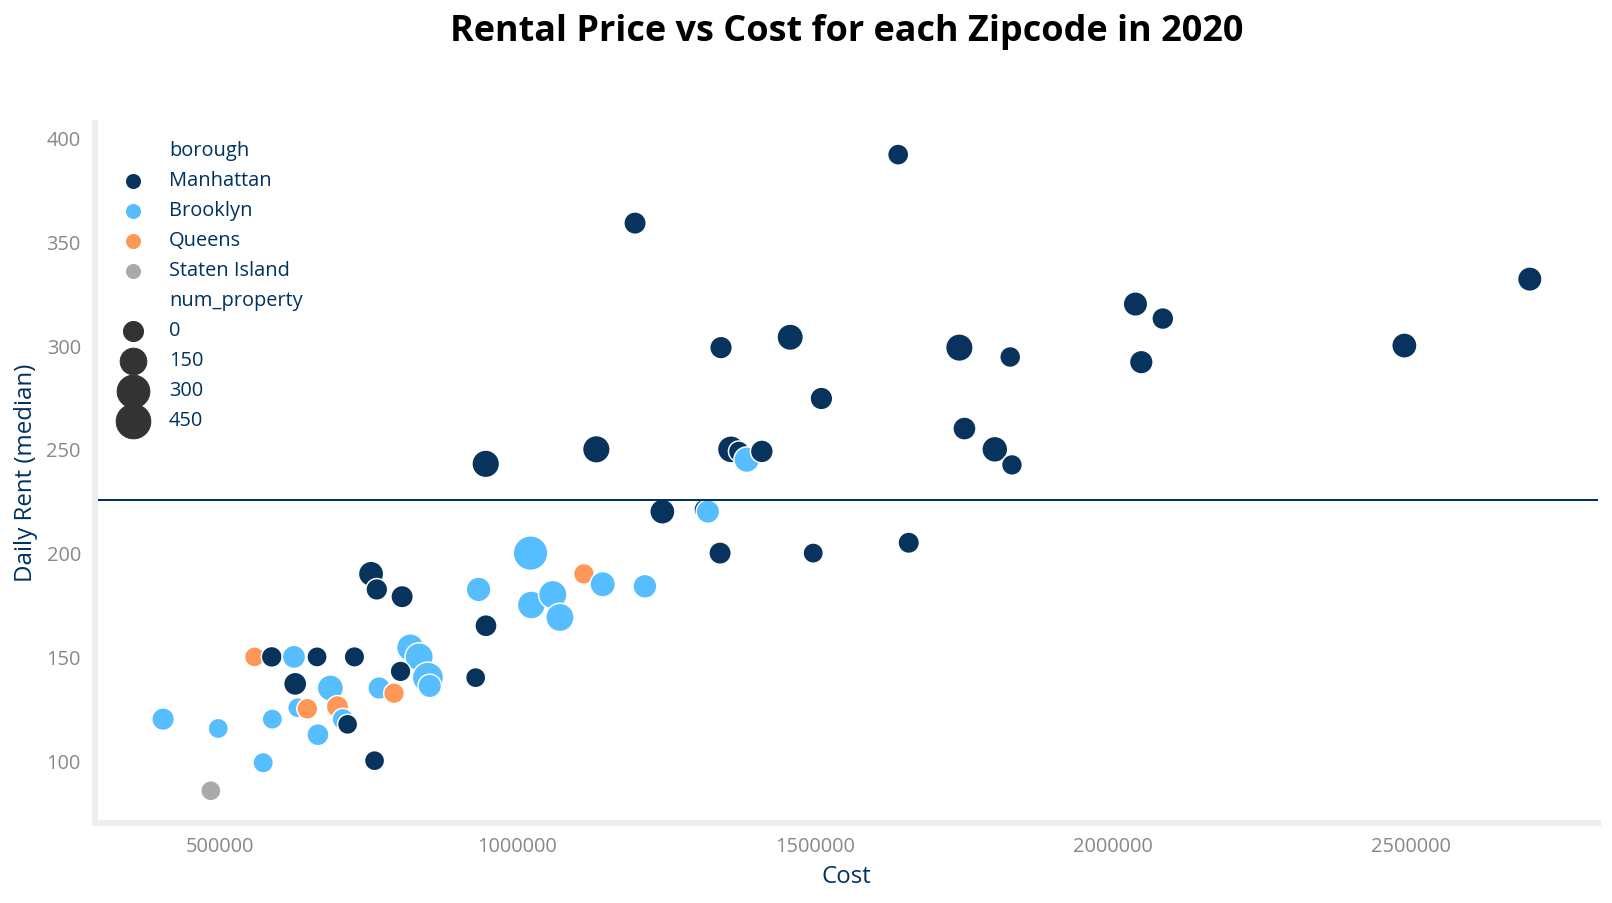

In [1543]:
#plt.style.use('fivethirtyeight')
themes.theme_ucberkeley(scheme="all", figsize=[12, 6])

sns.scatterplot(x="cost2020", y="med_rent", hue="borough",
                data=pay_2020,size='num_property',
                sizes=(100, 300),  
                palette=self_palette,
               )
plt.axhline(newdata_2020_3['price'].mean(),lw=1)
plt.title('Rental Price vs Cost for each Zipcode in 2020', fontsize=18, y=1.1, weight='bold',color='black')
ax.legend(title="borough", fontsize=10)
plt.xlabel('Cost',fontsize=12)
plt.ylabel('Daily Rent (median)',fontsize=12)

plt.show()

## Airbnb Rental Price across Zipcodes

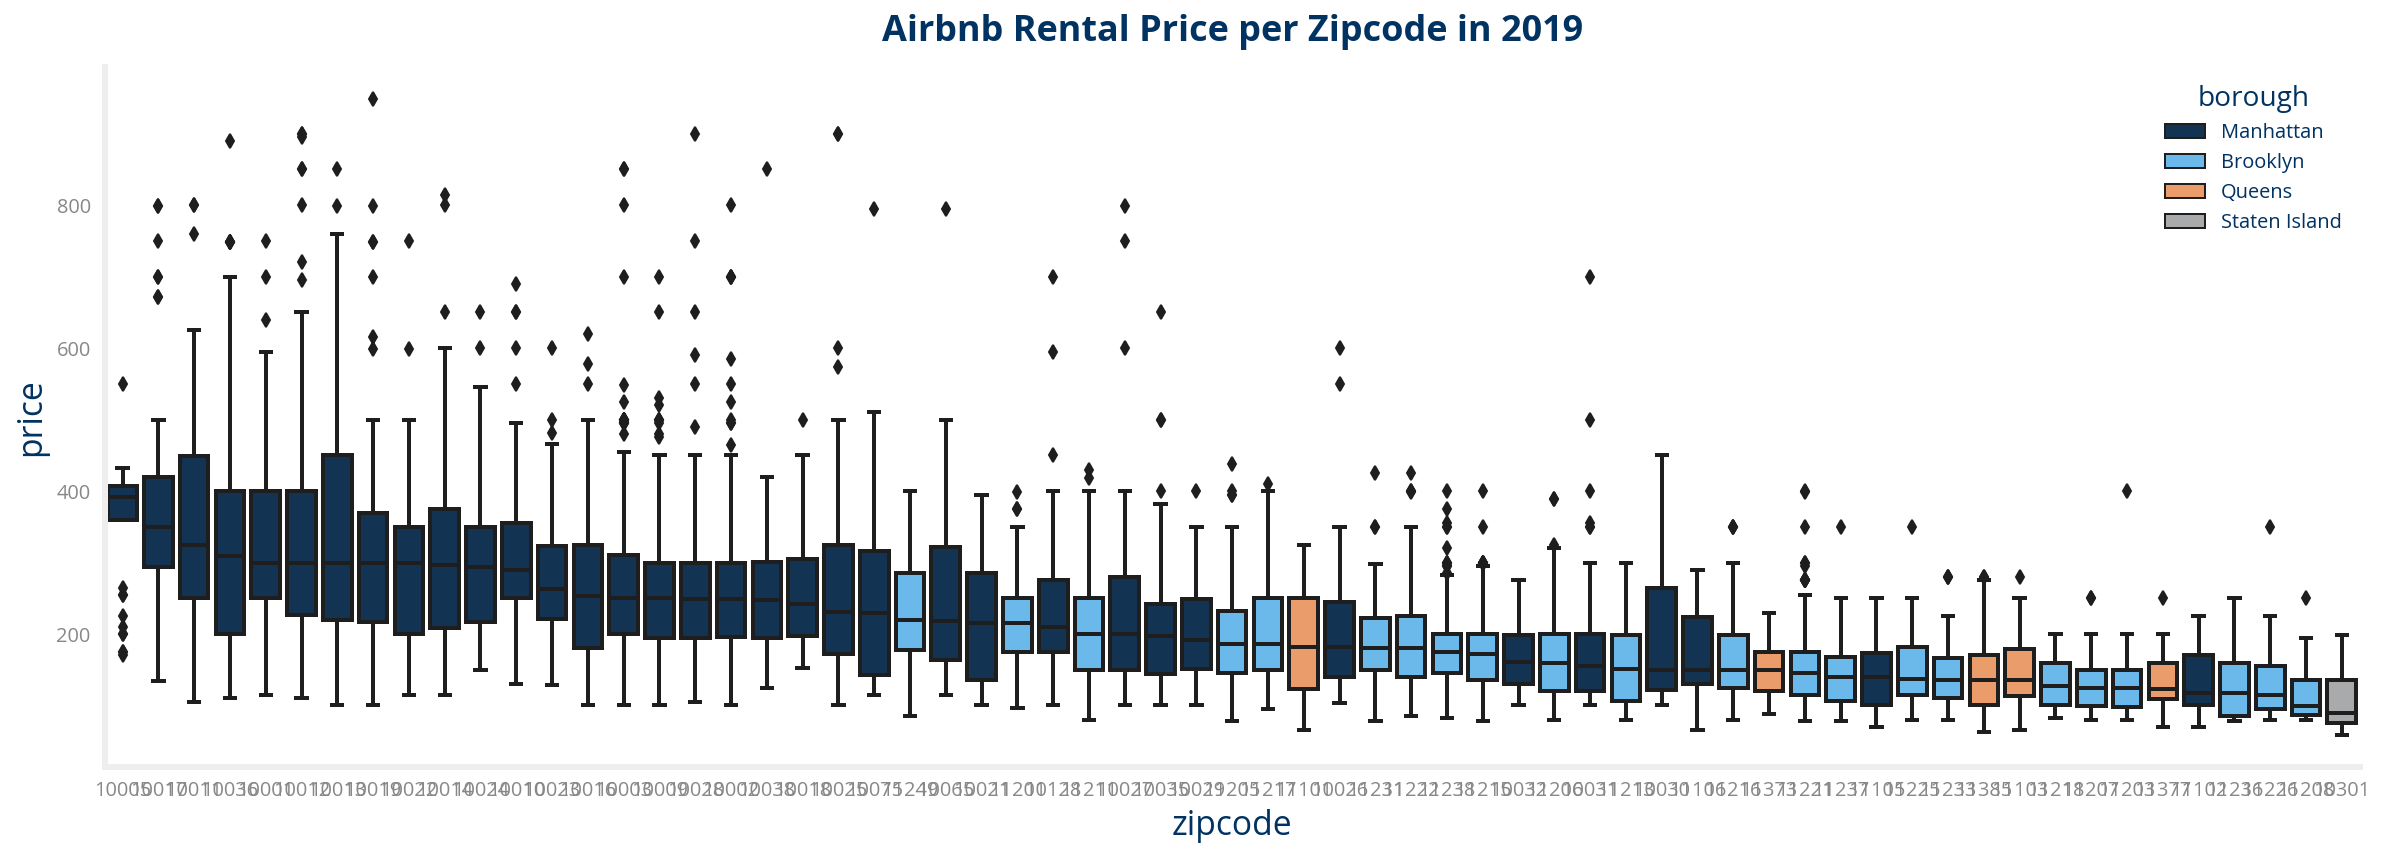

In [1547]:
# Airbnb rental price within zipcodes in 2019
themes.theme_ucberkeley(scheme="all", figsize=[12, 6])

plt.figure(figsize=(18,6))
zipcode_list = newdata_2020_3.groupby(['zipcode','borough'],as_index=False)['price'].median()
zipcode_list= zipcode_list.sort_values('price',ascending=False)

ax=sns.boxplot(x='zipcode',y='price',order=zipcode_list['zipcode'], palette=self_palette,
            hue="borough",dodge=False,
            data=newdata_2020_3, linewidth=2)

#plt.ylim(0, 1500)
plt.title('Airbnb Rental Price per Zipcode in 2019', fontsize=18, y=1.02, weight='bold')
ax.legend(title="borough", fontsize=10)

plt.show()

---

## Rental Property Density across NYC 

In [978]:
newdata_2020.groupby('borough',as_index=False)['zipcode'].count()

,borough,zipcode
0,Bronx,57
1,Brooklyn,2831
2,Manhattan,2863
3,Queens,466
4,Staten Island,55


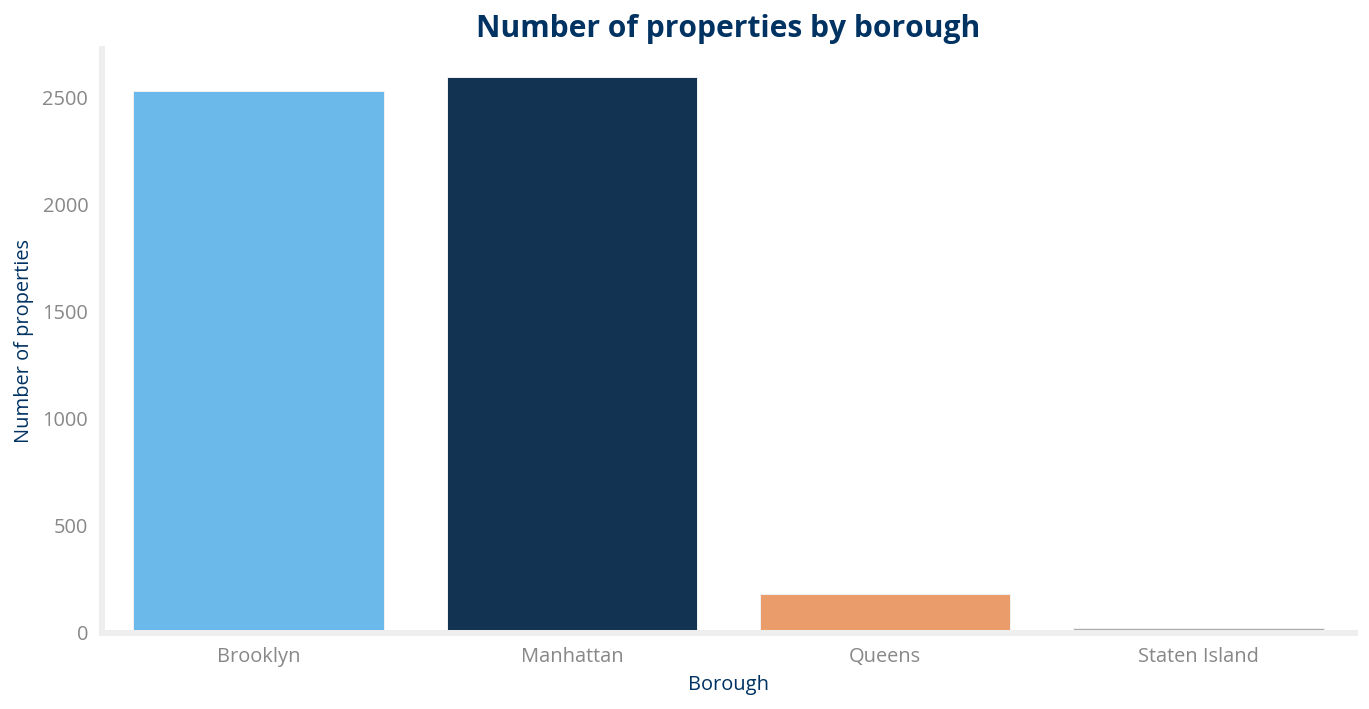

In [1548]:
 # Number of properties by neighbourhood
neigh_list = newdata_2020_3.groupby('borough',as_index=False)['zipcode'].count()

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
themes.theme_ucberkeley(scheme="all", figsize=[12, 6])

sns.barplot(x="borough", y="zipcode",palette=self_palette, data=neigh_list)
plt.title('Number of properties by borough', fontsize=15, weight='bold')
plt.xlabel('Borough', fontsize=10)
plt.ylabel('Number of properties', fontsize=10)
plt.show()

In [900]:
newdata_2020 = newdata_2020.groupby('borough').apply(lambda x : \
          x[x.num_property >x.num_property.quantile(0.25)]).droplevel(0)

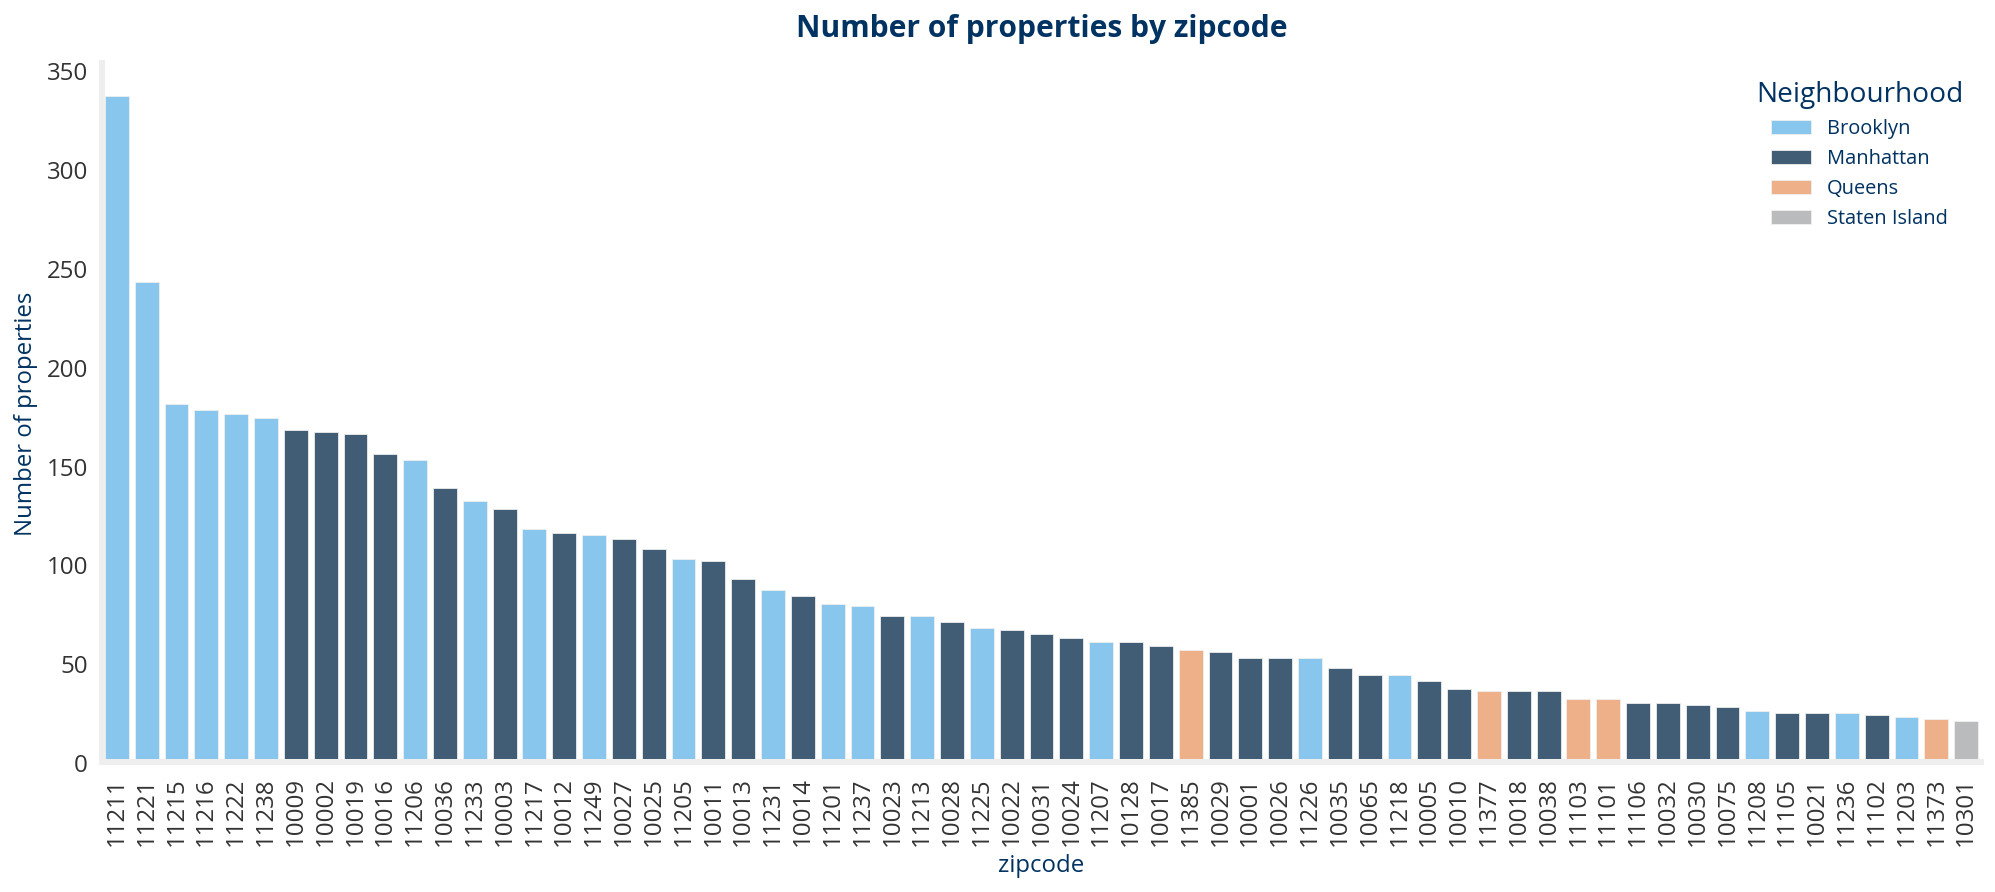

In [1549]:
# Code generating Fig6 in the report  # Number of properties by zipcodes

zipcode_list=newdata_2020_3.groupby(['zipcode','borough'],as_index=False)['price'].count()
zipcode_list=zipcode_list.sort_values('price',ascending=False)
fig, (ax) = plt.subplots(1, 1, figsize=(15,6))
themes.theme_ucberkeley(scheme="all")

sns.barplot(x="zipcode", y="price",order=zipcode_list['zipcode'],
palette=self_palette,hue='borough',dodge=False,alpha=.8,
            data=zipcode_list)
plt.title('Number of properties by zipcode',fontsize=15, y=1.02,weight='bold')
ax.legend(title="Neighbourhood", fontsize=10)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12,colors='#333333',)
ax.tick_params(axis = 'x', which = 'major', labelsize = 12,colors='#333333',rotation=90)

plt.xlabel('zipcode', fontsize=12)
plt.ylabel('Number of properties', fontsize=12)
#plt.text(1, -25, "Fig 1. Number of properties by zipcodes", fontsize=10, ha="center")    
plt.show()

---

# Breakeven Analysis

### ROI and Annual Revenue Analysis

**ROI From Rent**

$$ \text{ROI} = \frac{\text{Rental Price}* \text{Occupancy Rate} * \text{Time Period}}{ \text {Total Cost}}$$




**Considering Property Value Appreciation**

$$ \text{ROI} = \frac{\text{Rent}* \text{Occupancy} * \text{Time}+ \text{Appreciation Over Time} }{ \text {Cost}}$$

$$ \text{Breakeven Time}  = \frac{\text{Cost} - \text{Appreciation}}{ \text {Rental Price} * \text{Occupancy Rate} * 365}$$


`Time Period` is taken as `year` (365) days


Break even analysis taking the median price;  
For the purpose of decision making, sufficient data points are needed to calculate ROI, hence zipcodes with less than 10 properties are filtered out.

In [1616]:
# Function to calculate breakeven time in year, with two aggregation methods

def ROI(df, year):
    df2 = df.copy() 
    col_year = 'cost'+ str(year)
#    temp = df.groupby(['zipcode','borough']).size()
    med_price = df2.groupby(['zipcode'],as_index=False)['price'].median().rename(columns={'price':'med_rent'})
    avg_price = df2.groupby(['zipcode'],as_index=False)['price'].mean().rename(columns={'price':'avg_rent'})
    df2 = df2.drop(['price'], axis=1).drop_duplicates(keep='first')
    df2=df2.merge(avg_price, on='zipcode',how='right')
    df2=df2.merge(med_price, on='zipcode',how='right')
    df2['annual_rent']=df2['med_rent']*365*0.75
    df2['annual_rent_avg']=df2['avg_rent']*365*0.75

    df2['CAP'] = (df2['annual_rent'])/ df2[col_year]
    df2['payback_time'] = (1/df2['CAP']).round(2)
    df2['payback_yr'] = ((1/df2['CAP']).round(0)).astype(int)
    df2 = df2.sort_values(by='payback_time')   
    
    if year>2020:    
        df2['rev'+str(year)] = df2['annual_rent'] * (year-2020) + df2[col_year] - df2['cost2020']
        df2['ROI'] = df2['rev'+str(year)] / df2['cost2020']
        df2 = df2.sort_values(by='ROI', ascending=False)   
     
    return df2

In [1617]:
pay_2020 = ROI(newdata_2020_3, 2020)

In [1619]:
pay_2030 = ROI(newdata_2020_3, 2030)

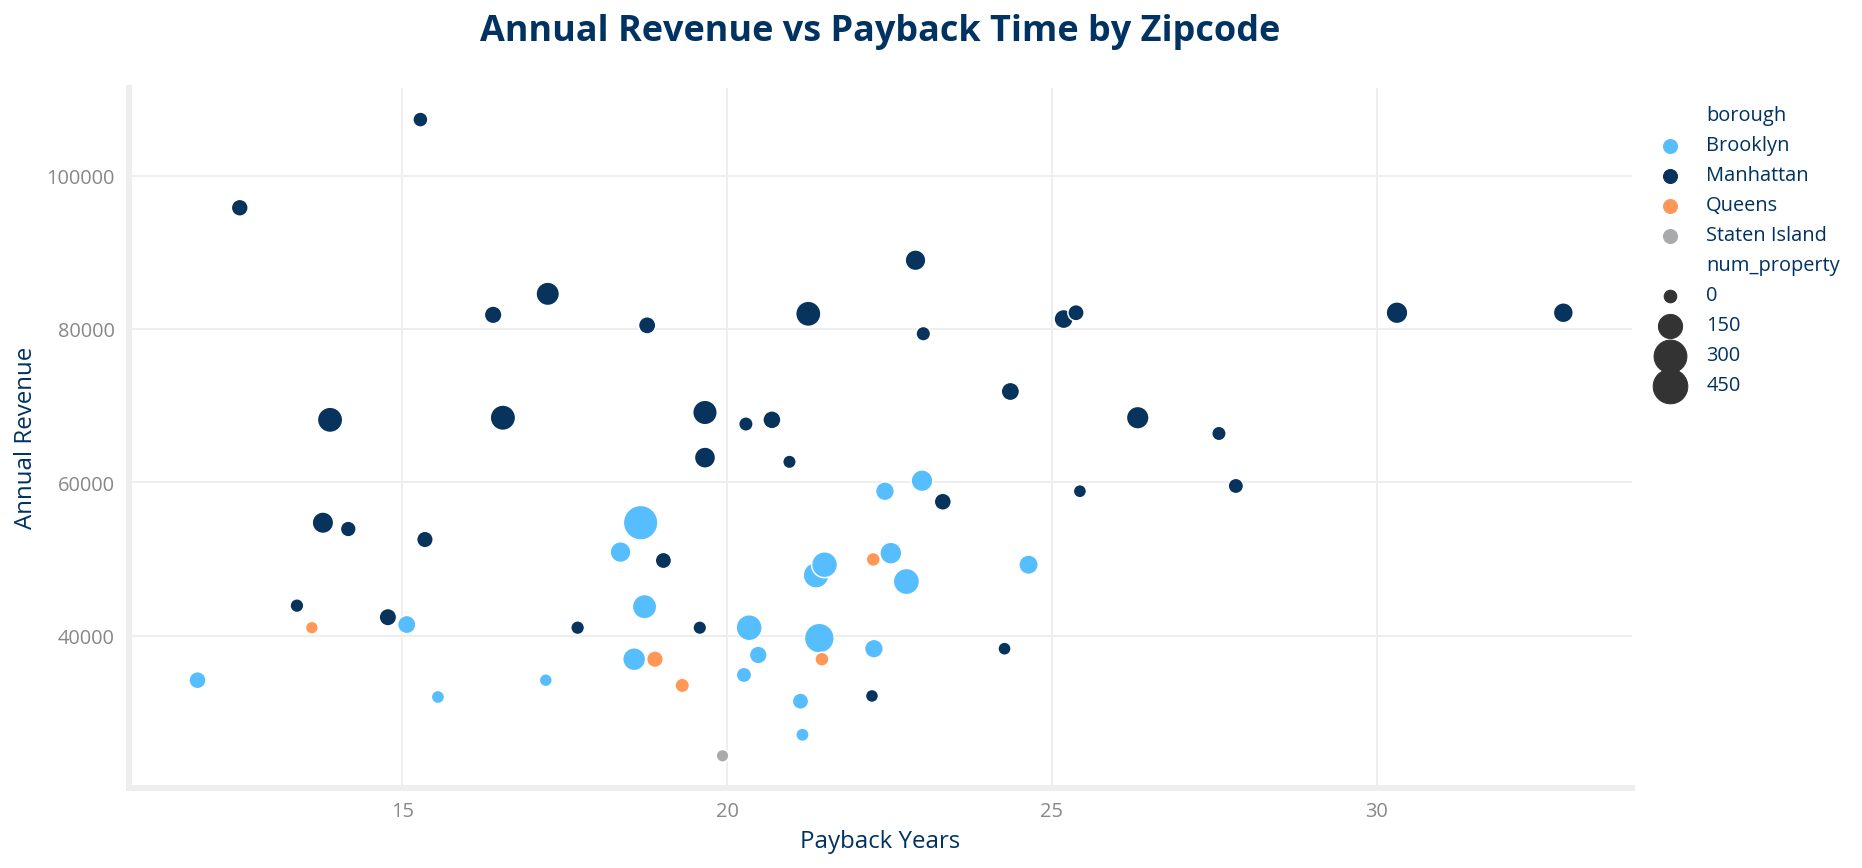

In [1560]:
themes.theme_ucberkeley(scheme="all", figsize=[12, 6],grid=True)
med_payback = pay_2020.cost2020.median()/pay_2020.annual_rent.median()

sns.scatterplot(y='annual_rent',x='payback_time',data=pay_2020, hue='borough',
size='num_property',sizes=(40,300),
                palette=self_palette,)
           #     palette ={'Brooklyn':'#00CC96',
            #  'Manhattan':'#f0664e','Staten Island':'#B6E880', 'Queens':'#99c4ec','Bronx':'#cfa7fc'}

#plt.axhline(pay_2020['annual_rent'].quantile(.5), ls='--',lw=2)
#plt.axvline(12, ls='--',lw=2, )
#plt.axhline(pay_2020['annual_rent'].quantile(.8), ls='--',lw=2,)
#plt.text(12,pay_2020['annual_rent'].quantile(.92), '0.8 quantile')

plt.title('Annual Revenue vs Payback Time by Zipcode', fontsize=18, y=1.05, weight='bold')
#ax.legend(title="Borough", fontsize=10, loc='upper right')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.xlabel('Payback Years',fontsize=12)
plt.ylabel('Annual Revenue',fontsize=12)

plt.show()

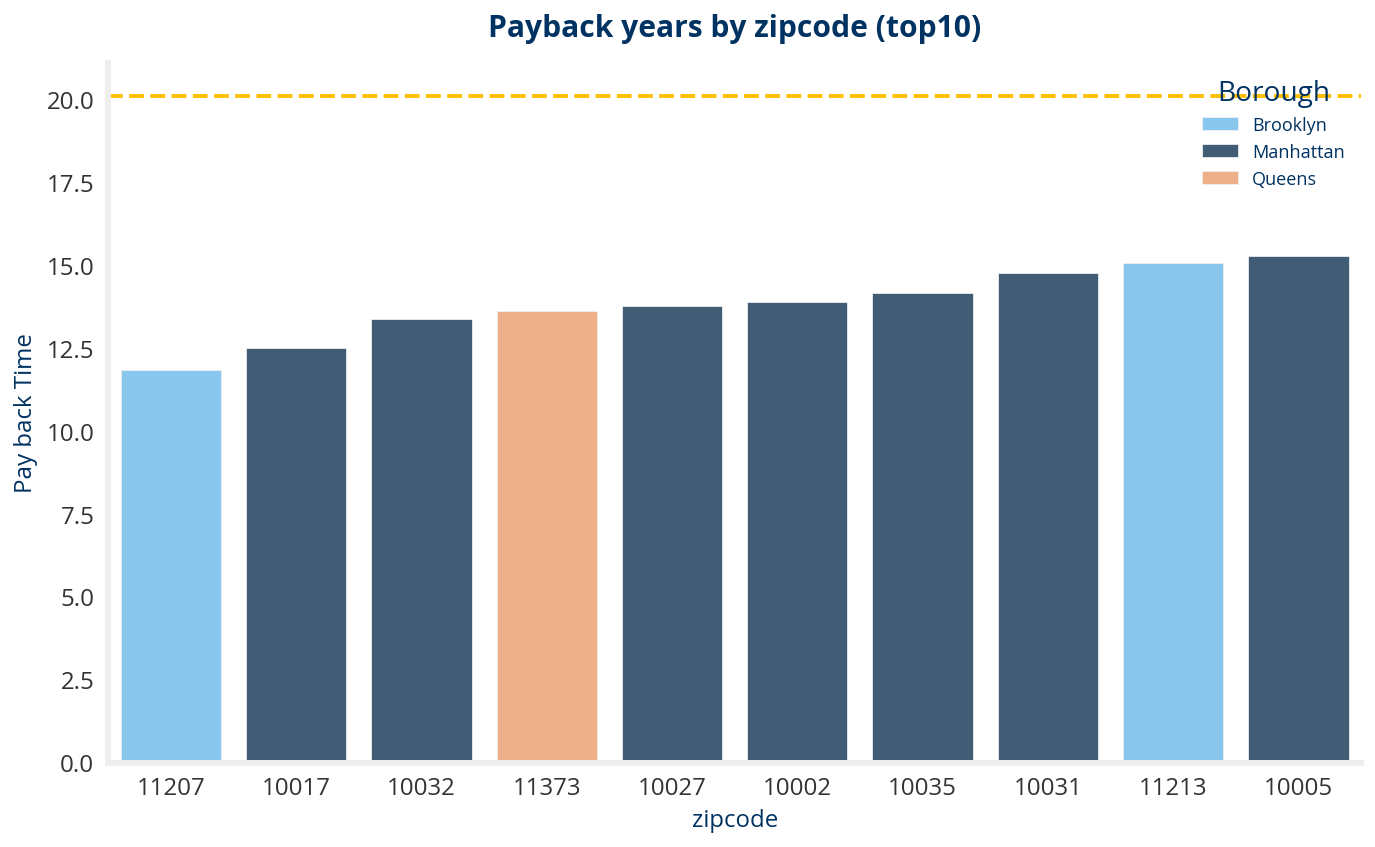

In [1565]:
from numpy import median
fig, (ax) = plt.subplots(1, 1, figsize=(10,6))
med_payback = pay_2020.cost2020.median()/pay_2020.annual_rent.median()

#themes.theme_minimal()
themes.theme_ucberkeley(scheme='all')
#themes.theme_ggplot2(palette=themes.palettes.FiveThirtyEight.colors)
df=pay_2020.sort_values(by='payback_time').iloc[:10,]

sns.barplot(x='zipcode',y='payback_time',
            hue="borough",palette=self_palette,
            dodge=False, order=df['zipcode'],alpha=.8,
            data=df)

plt.title('Payback years by zipcode (top10)',fontsize=15, y=1.02, weight='bold')
ax.legend(title="Borough", fontsize=9)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12,colors='#333333',)
#ax.tick_params(axis = 'x', which = 'major', labelsize = 12,colors='#333333',rotation=90)
plt.axhline(med_payback, ls='--',lw=2,c='#ffc107')

plt.xlabel('zipcode', fontsize=12)
plt.ylabel('Pay back years', fontsize=12)
#plt.text(1, -25, "Fig 1. Number of properties by zipcodes", fontsize=10, ha="center")    
plt.show()

In [1551]:
pay_2020['rev2025'] = pay_2020['annual_rent'] * 5 + pay_2020['cost2025']-pay_2020['cost2020']
pay_2020['roi2025'] = pay_2020['rev2025']/pay_2020['cost2020']

In [ ]:
pay_2020['appreciation'] = pay_2020['cost2025'] - pay_2020['cost2020']

---

### ROI in five years

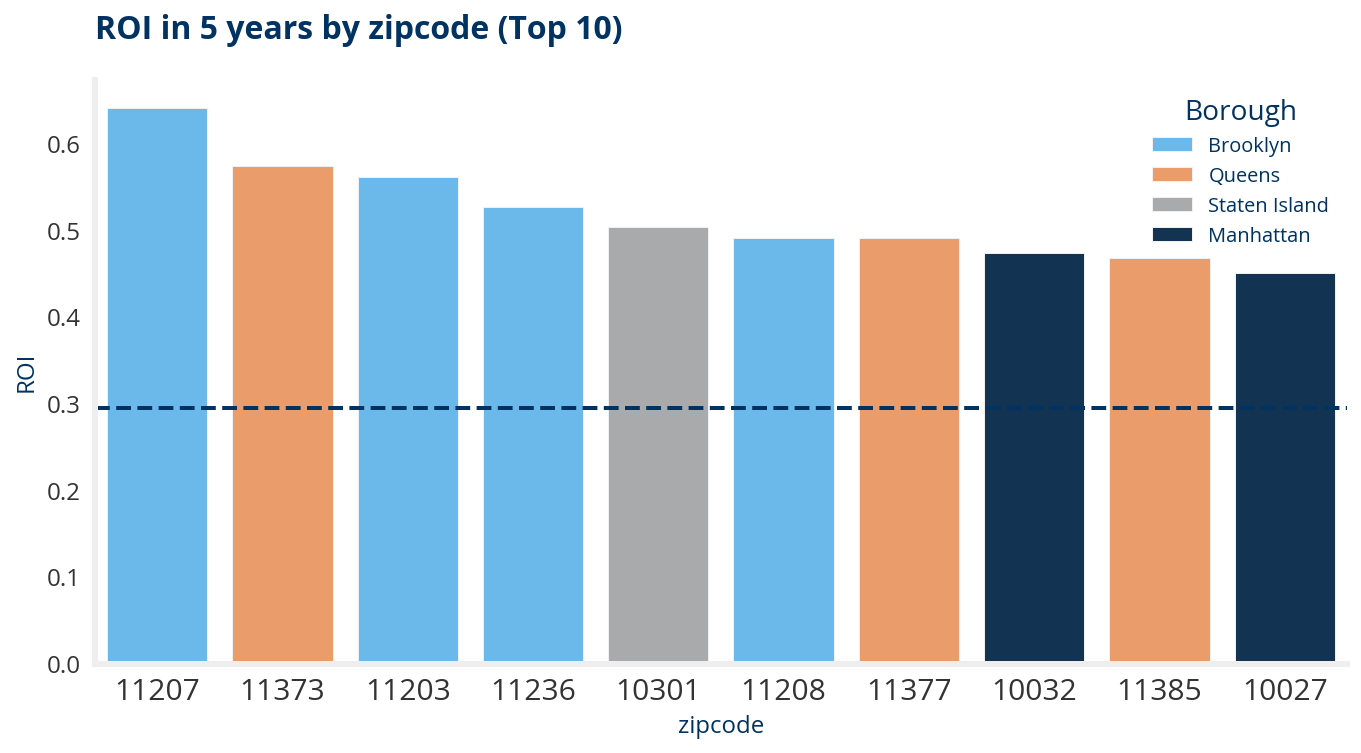

In [1592]:
from numpy import median
fig, (ax) = plt.subplots(1, 1, figsize=(10,5))

themes.theme_ucberkeley()
df =pay_2020.sort_values(by='roi2025', ascending=False).iloc[:10,:]
sns.barplot(x='zipcode',y='roi2025',
            hue="borough",palette=self_palette,
            dodge=False,order=df['zipcode'],
            data=df)
ax.axhline(pay_2020['roi2025'].mean(), ls='--',lw=2,)
ax.set_title('ROI in 5 years by zipcode (Top 10)', loc='left',fontsize=16, y=1.05, weight='bold')
ax.legend(title="Borough", fontsize=10)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12,colors='#333333',)
ax.tick_params(axis = 'x', which = 'major', labelsize = 15,colors='#333333',
               #rotation=90
              )
plt.xlabel('zipcode', fontsize=12)
plt.ylabel('ROI', fontsize=12)
#plt.text(1, -25, "Fig 1. Number of properties by zipcodes", fontsize=10, ha="center")    
plt.show()

### Reproducible Function to Generate Plots

In [1345]:
# Function generates Figure 7- Annual Gross Revenue 
def plots_revenue(df,year):   
    
    #themes.theme_ucberkeley(scheme="all")
   # plt.style.use('fivethirtyeight')
    #themes.theme_few(scheme="medium")
    f, ax1  = plt.subplots(figsize=(16, 6))
    data = df.sort_values(by='annual_rent',ascending=False).iloc[:30,:]
    data['annual_rent']=data['annual_rent']/1000
    splot=sns.barplot(y= data["annual_rent"], palette=self_palette,
                      x="zipcode",hue='borough',
                order = data['zipcode'],data=data,dodge=False)   
    plt.title('Annual Rental Revenue($K) by zipcode (Top30)',weight="bold", fontsize=18)
    
    ax1.axhline(data['annual_rent'].mean(), ls='--',lw=2)
    for p in splot.patches:
        width = p.get_width()/2 + p.get_x()
        yloc = p.get_height()
        splot.annotate(format(yloc,'.0f'),
                       (width,yloc),ha = 'center', va='center',fontsize = 8,
                     xytext=(0, 5),textcoords="offset points")
    
    ax1.legend(title="Neighbourhood", fontsize=10,loc='upper right')

    ax1.tick_params(axis = 'both', which = 'major',
                   labelcolor='black', labelsize='medium', width=3)
    ax1.tick_params(axis = 'x', which = 'major', labelsize = 12,colors='#333333',rotation=90)

    plt.xlabel('zipcode', fontsize=12)
    plt.ylabel('Annual Revenue', fontsize=12)

   # plt.text(1, -1000, "Fig 9. Annual Rental Revenue by zipcodes in {}".format(year), fontsize=12, ha="center")    
    plt.show()

In [1031]:
# Function generating Fig7,9,11 in the report  
# Break even period by zipcode, color is encoded as neighborhood
def plot_breakeven(df, year):
    
    themes.theme_ucberkeley(scheme="all")
    
    fig, (ax) = plt.subplots(1, 1, figsize=(5,10))
    splot=sns.barplot(x="payback_time", y="zipcode",hue='borough',
palette=self_palette,
                      order = df['zipcode'],
                data=df,orient='h',dodge=False)
    plt.title('Break even time by zipcode in {0}'.format(year),fontsize=15, weight='bold',y=1.02)
    plt.ylabel('Zipcode', fontsize=12)
    plt.xlabel('Breakeven years', fontsize=13)
    
    for p in splot.patches:
        width = p.get_width()
        yloc = p.get_y() + p.get_height() / 2
        splot.annotate(format(width, '.1f'),
                       (width, yloc),
                    ha = 'center', va='center',
                     xytext=(10, 0), textcoords="offset points")
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor='black')
    ax.legend(title="Borough", fontsize=10)
    plt.show()

In [441]:
# Function generating Fig9 in the report  
def plot_roi(df, year):
    #plt.style.use('fivethirtyeight')
    themes.theme_ucberkeley(scheme="all")

    df = df.sort_values('ROI',ascending=False)
    fig, (ax) = plt.subplots(1, 1, figsize=(5,10))
    splot=sns.barplot(x="ROI", y="zipcode",hue='neighbourhood',palette=self_palette,
                     # palette=sns.color_palette('Paired'),
                order = df['zipcode'],
                data=df, orient='h',dodge=False)
    plt.title('ROI by zipcode by the Year of {0}'.format(year),fontsize=15,y=1.01,weight='bold')
    plt.ylabel('Zipcode', fontsize=12)
    plt.xlabel('ROI', fontsize=12)

    for p in splot.patches:
        width = p.get_width()
        yloc = p.get_y() + p.get_height() / 2
        splot.annotate(format(width, '.2f'),
                       (width, yloc),
                    ha = 'center', va='center',
                     xytext=(-14, 0),textcoords="offset points")
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor='black')
    ax.legend(title="Neighbourhood", fontsize=10)
    plt.show()

In [1589]:
# Function generates Fig10 in the report  # ROI & Gross Revenue in the future
def plots_ROIvsRevenue(df,year):   
    data=df[['annual_rent','payback_time','CAP','zipcode','borough']]
    data=data.sort_values(by='payback_time').iloc[:5,:]
    
    f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
    
    sns.barplot(x="payback_time", y="zipcode",hue='borough',palette=self_palette,
                order = data['zipcode'],
                data=data, orient='h',dodge=False, ax=ax1)   
  
    sns.barplot(x="annual_rent",
                y="zipcode",hue='borough',palette=self_palette,
                order = data['zipcode'],
                data=data, orient='h',dodge=False, ax=ax2)   
    
    med_payback = pay_2020.cost2020.median()/pay_2020.annual_rent.median()
 
    ax2.axvline(df['annual_rent'].mean(), ls='--',lw=2)
    ax1.axvline(med_payback, ls='--',lw=2)
    ax1.set_title('Payback years by zipcode (Top 5)',fontweight="bold", size=15, pad=10)
    ax2.set_title('Annual rental revenue ($K)',fontweight="bold", size=15,pad=10)
    ax2.set_xlabel('Rent Revenue(K)', fontsize=15)
    ax1.set_xlabel('Year', fontsize=15)
    ax1.legend(title="Borough", fontsize=8)
    for p in ax1.patches:
        width = p.get_width()
        yloc = p.get_y() + p.get_height() / 2
        ax1.annotate(format(width, '.1f'),
                    (width, yloc),ha = 'center', va='center',fontsize=12,
                     xytext=(11, 0),textcoords="offset points")
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor='black')
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12,labelcolor='black')

    plt.tight_layout(pad=4, w_pad=5, h_pad=10)
    ax1.get_legend().remove()
    plt.show()

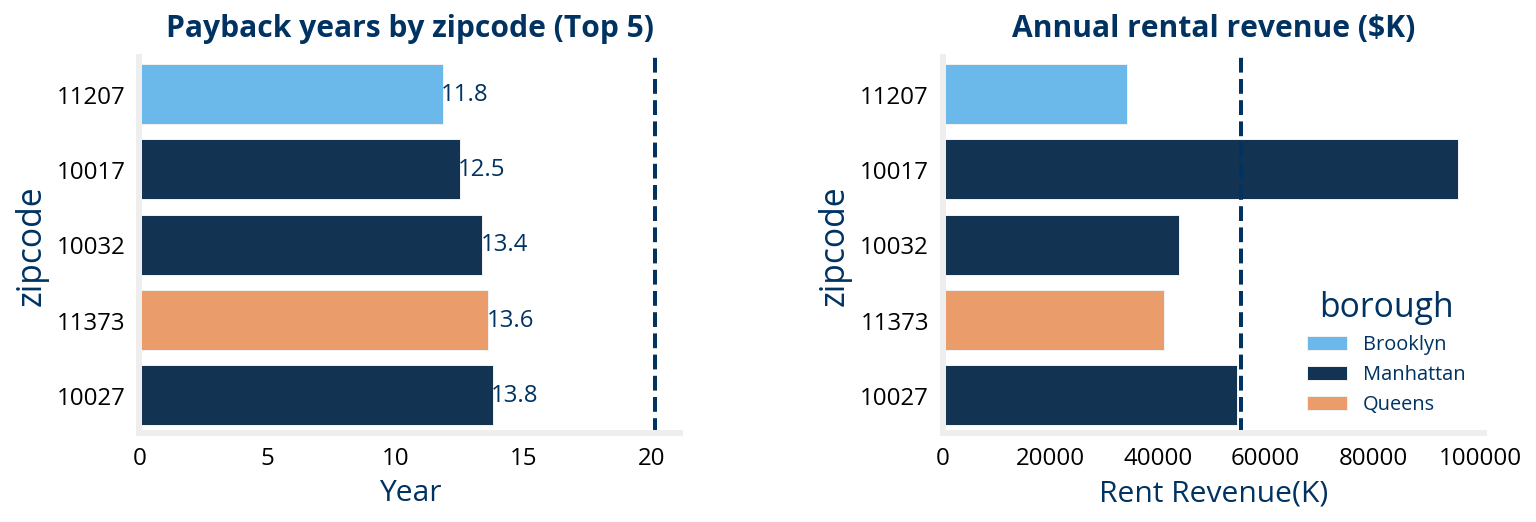

In [1590]:
plots_ROIvsRevenue(pay_2020,2020)

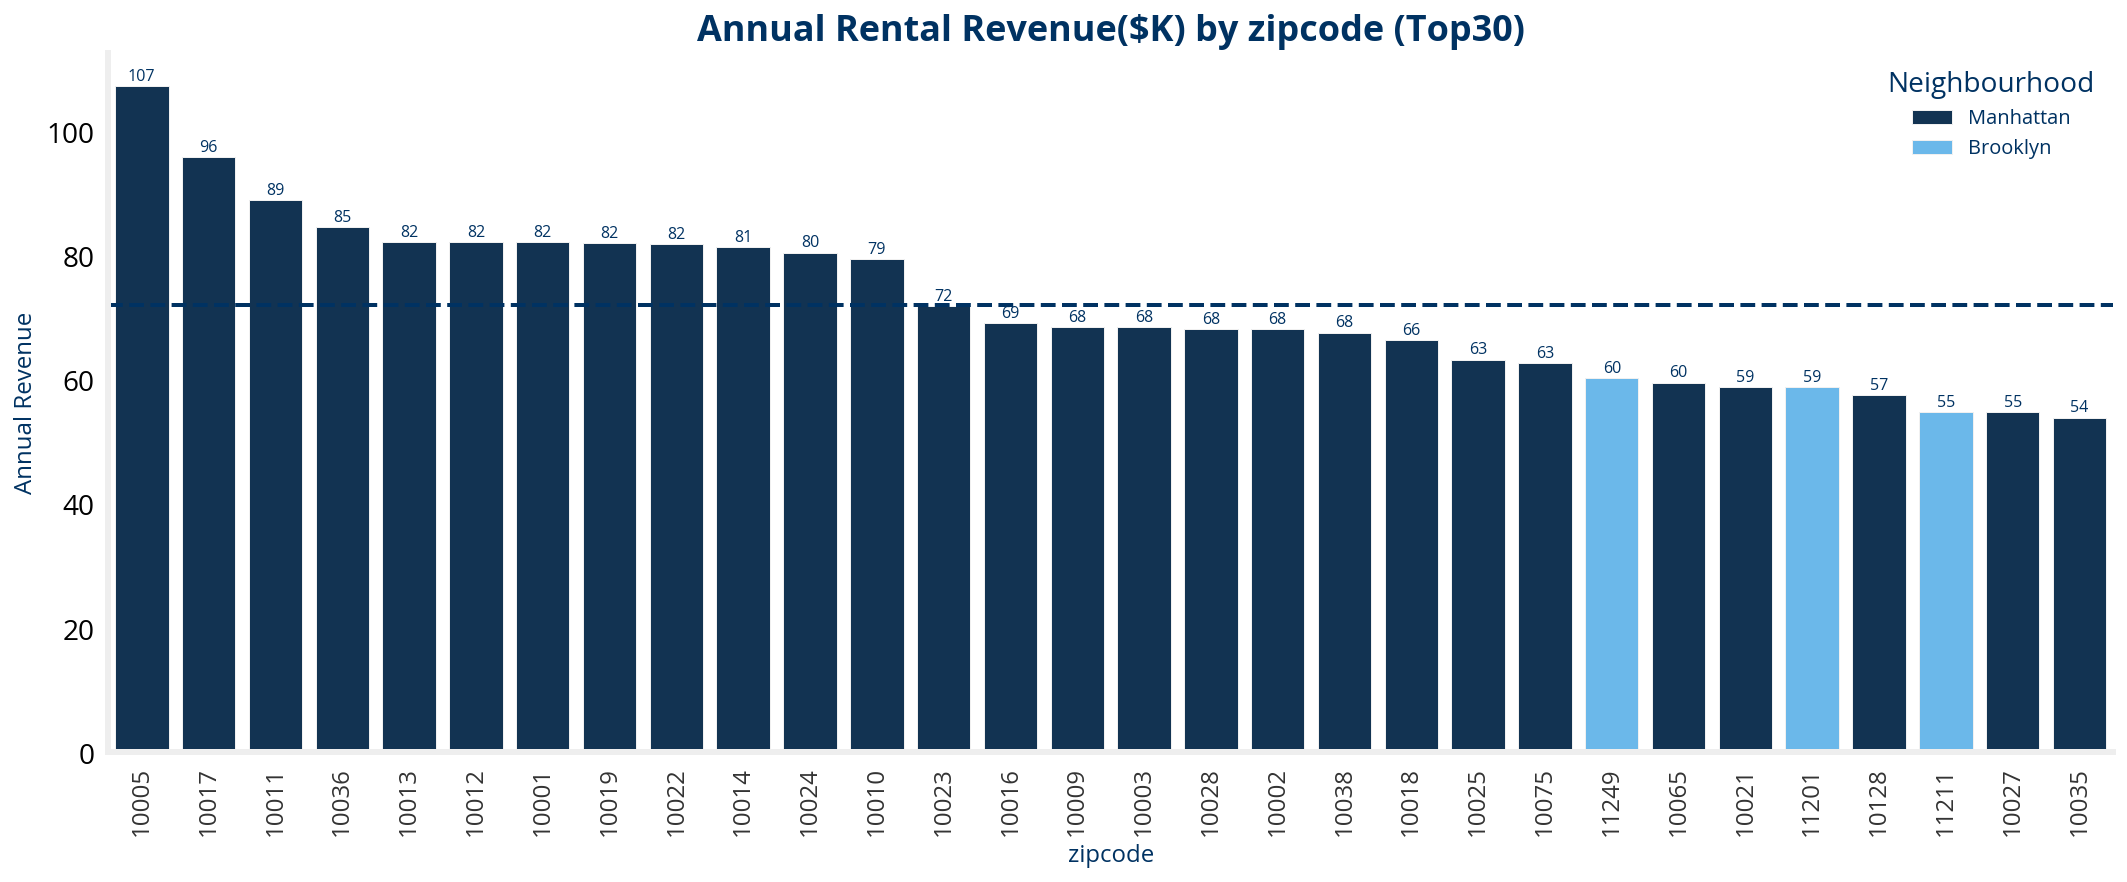

In [1566]:
plots_revenue(pay_2020,2020)

### Payback After 10 Years

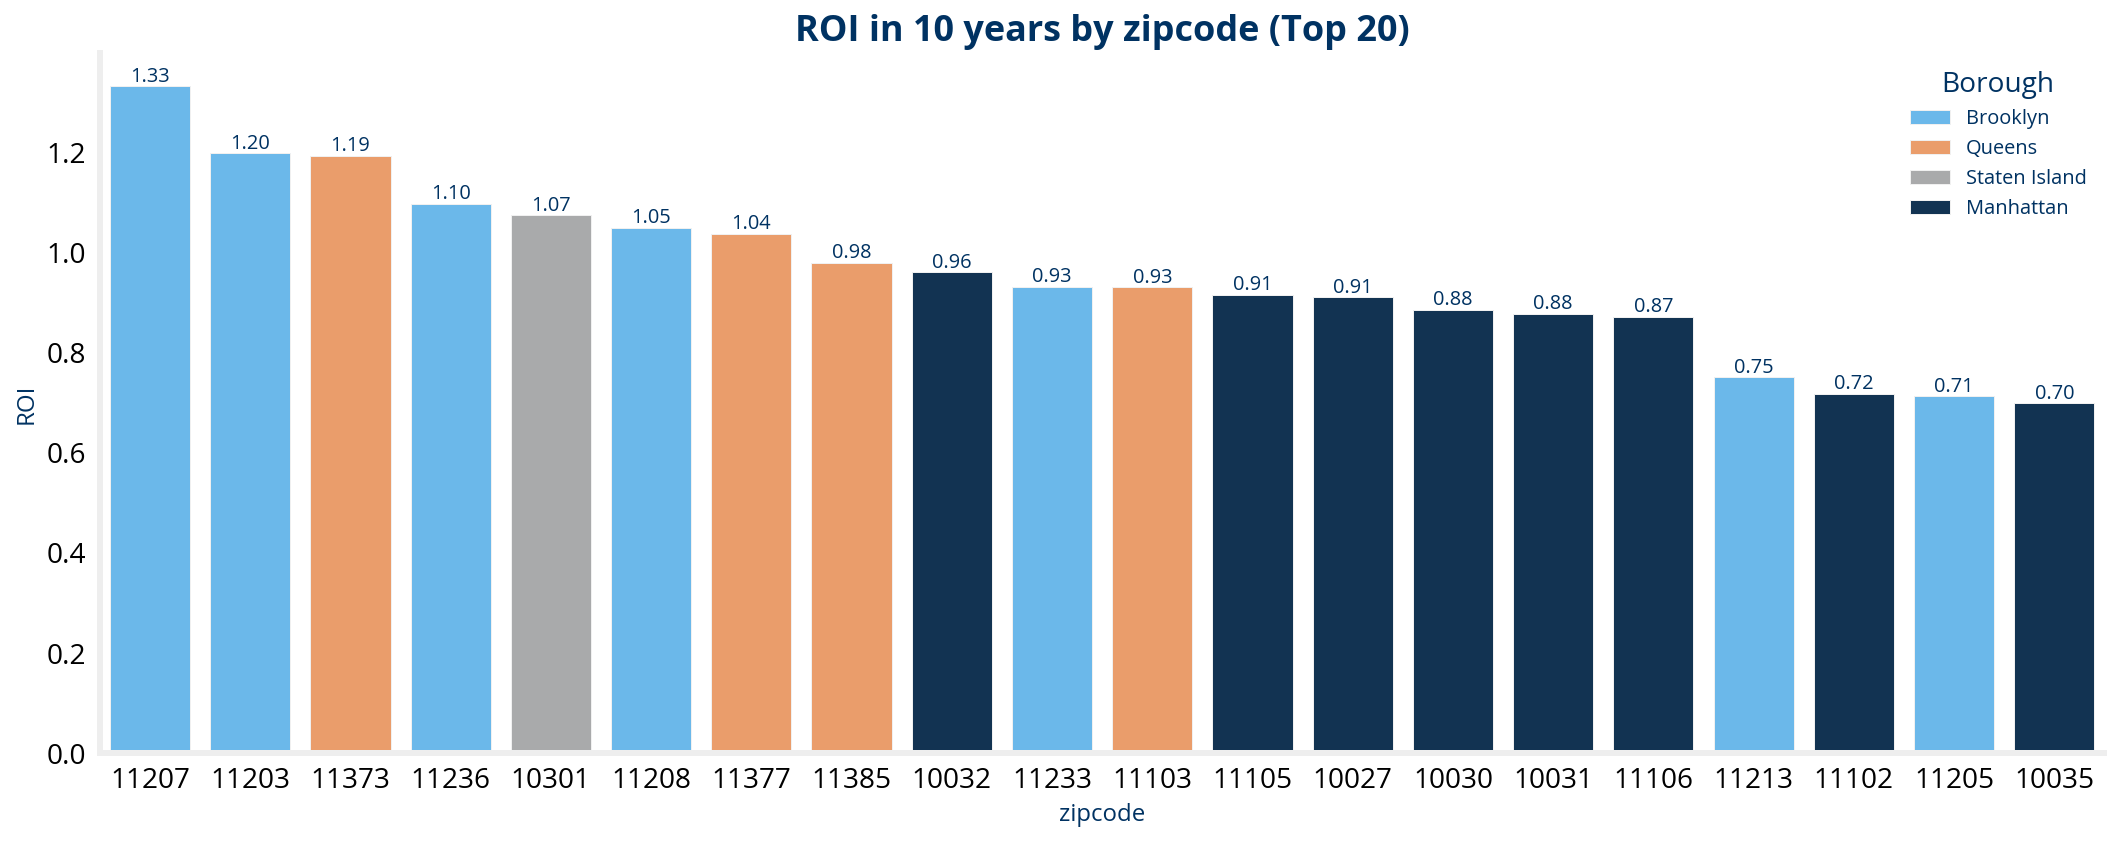

In [1625]:
# Function generates Figure 7- Annual Gross Revenue 
themes.theme_ucberkeley(scheme="all")

f, ax1  = plt.subplots(figsize=(16, 6))
data = pay_2030.sort_values(by='ROI',ascending=False).iloc[:20,:]

data['rev2030']=data['rev2030']/1000

splot=sns.barplot(y= data["ROI"], palette=self_palette, x="zipcode",hue='borough',
                order = data['zipcode'], data=data, dodge=False)   
plt.title('ROI in 10 years by zipcode (Top 20)',weight="bold", fontsize=18)
    
#ax1.axhline(data['rev2025'].mean(), ls='--',lw=2)
for p in splot.patches:
    width = p.get_width()/2 + p.get_x()
    yloc = p.get_height()
    splot.annotate(format(yloc,'.2f'),
                       (width,yloc),ha = 'center', va='center',fontsize = 10,
                     xytext=(0, 5),textcoords="offset points")
    
ax1.legend(title="Borough", fontsize=10,loc='upper right')

ax1.tick_params(axis = 'both', which = 'major',
                   labelcolor='black', labelsize='medium', width=3)
#ax1.tick_params(axis = 'x', which = 'major', labelsize = 12,colors='#333333',rotation=90)

plt.xlabel('zipcode', fontsize=12)
plt.ylabel('ROI', fontsize=12)

   # plt.text(1, -1000, "Fig 9. Annual Rental Revenue by zipcodes in {}".format(year), fontsize=12, ha="center")    
plt.show()

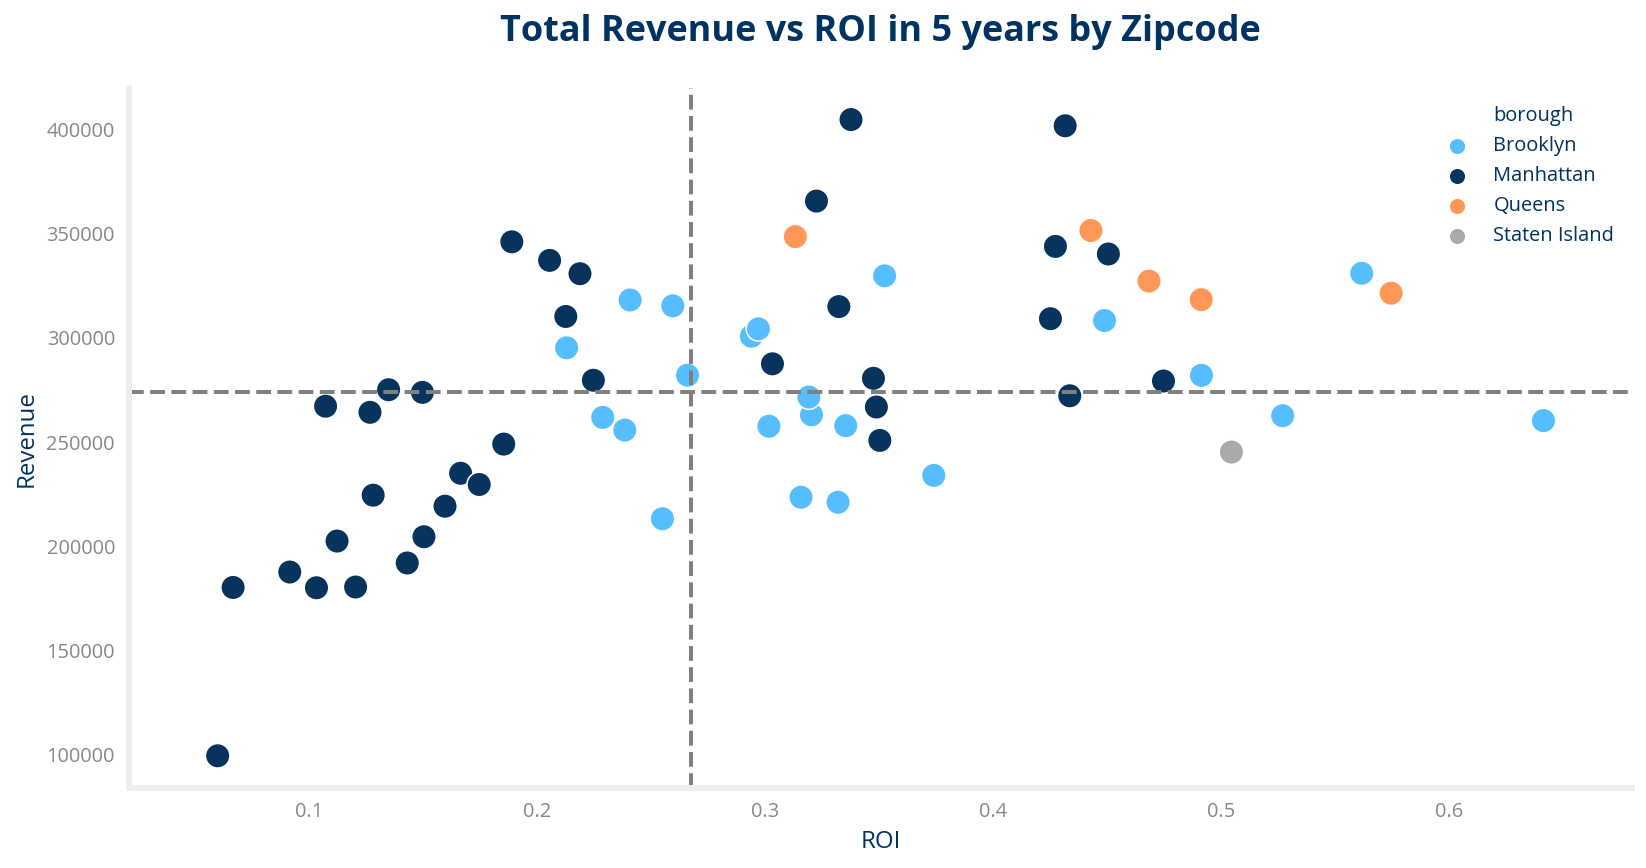

In [1599]:

med_roi = pay_2020['rev2025'].median()/pay_2020['cost2020'].median()
#plt.style.use('fivethirtyeight')
themes.theme_ucberkeley(scheme="all", figsize=[12, 6],grid=False)

sns.scatterplot(x='roi2025',y='rev2025',data=pay_2020, hue='borough',s=150,
#size='num_property',sizes=(40,300),
                palette=self_palette,)
           #     palette ={'Brooklyn':'#00CC96',
            #  'Manhattan':'#f0664e','Staten Island':'#B6E880', 'Queens':'#99c4ec','Bronx':'#cfa7fc'}

#plt.axhline(pay_2020['annual_rent'].quantile(.5), ls='--',lw=2)
plt.axvline(med_roi, ls='--',lw=2,c='grey')
plt.axhline(pay_2020['rev2025'].median(), ls='--',lw=2, c='grey')
#plt.text(12,pay_2020['annual_rent'].quantile(.92), '0.9 quantile')

#plt.ylim(0, 1000)

plt.title('Total Revenue vs ROI in 5 years by Zipcode', fontsize=18, y=1.05, weight='bold')
#ax.legend(title="Borough", fontsize=10, loc='upper right')
#plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.xlabel('ROI',fontsize=12)
plt.ylabel('Revenue',fontsize=12)

plt.show()

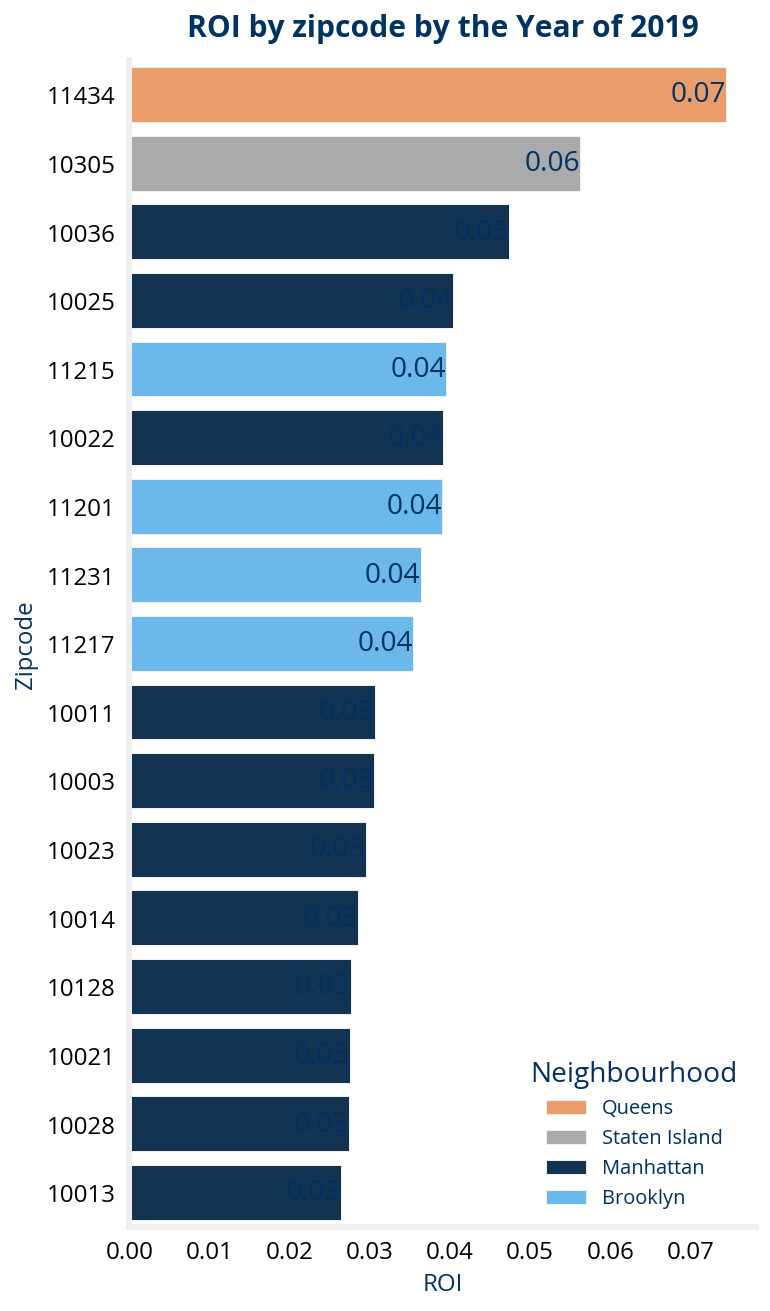

In [1596]:
plot_roi(payback_2019,2019)

---

# Future Steps


1.	A flat occupancy rate of 75% can be corrected with more data. Neighborhoods such as Staten Island have low rent prices but way fewer properties listed. Considering it's location, it is probable they have low occupancy rate but due to the static rate used in the analysis, we have to assume its occupancy to be equal to a property in Manhattan or Brooklyn.
Possible solution: Integrate data from public data sources and from related real estate agencies, to build more reliable occupancy rate model.
2.	Data, being old, doesn't confirm the actual landscape of market trends.
Possible solution: Create a more robust prediction model for current price.
3.	Consider seasonality in Airbnb rental prices whenever available to obtain more robust break even estimates. Weekly and monthly rent is cheaper than nightly rent, so considering longer terms would give us the worst-case scenario.
4.	Factors such as transportation, proximity to work location can be used to map the area for long-term rentals; Crime score is an important factor in determining the price. Crime score is freely available online and can be used for deeper analysis.
5.	Majority of the tourists book short term rentals in NY city hence holidays (variable pricing can be done ) and closeness to tourist locations should be accounted for.

---